# Path Planning for Autonomous Four-Wheel Steering Forklifts

This notebook demonstrates the implementation of path planning algorithms for autonomous forklifts with four-wheel steering capabilities. We explore how to combine advanced motion control with state-based planning to achieve efficient and natural navigation behaviors in constrained environments.

## 1. Introduction and Background

The automation of material transport in modern manufacturing environments presents significant challenges, particularly in confined spaces where traditional path planning methods often fail to fully exploit vehicle capabilities. This notebook presents a comprehensive approach to autonomous forklift navigation that leverages four-wheel steering (4WS) capabilities through three key innovations:

1. A path planning algorithm based on the Hamiltonian Fast Marching Method that explicitly considers 4WS kinematic constraints
2. A state system for managing different operational modes (forward/backward motion, specialized maneuvering)
3. An enhanced obstacle avoidance strategy using multi-ball approximation

The mathematical foundation of our approach builds on the Hamilton-Jacobi-Bellman equation:

$$
\forall q \in \Omega, \quad H_q(\nabla U(q)) = \frac{1}{2}c(q)^2, \quad \forall q \in \partial \Omega, \quad U(q) = \sigma(q)
$$

where $U(q)$ represents the minimum time to reach the target set $\partial \Omega$ from state $q$. 

## 2. Environment Setup

### 2.1 Required Libraries

In [1]:
import sys
import os

current_dir = os.path.abspath(os.getcwd())

from agd import Eikonal 
from agd import AutomaticDifferentiation as ad
from agd import Plotting
from scipy import ndimage
import time
import subprocess

Initialize CUDA environment if available. The path planning implementation requires GPU acceleration for efficient computation of the Fast Marching Method

In [2]:
import numpy as np; xp = np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors

try :import cupy
except ModuleNotFoundError: raise ad.DeliberateNotebookError("A cuda enabled gpu is required for this notebook")

xp,plt,Eikonal = map(ad.cupy_friendly,(xp,plt,Eikonal))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .


### 2.2 Utility Functions

`draw_bot`: Visualizes the forklift configuration along computed paths


In [3]:
def draw_bot(gamma,
             nb_pt = 10, 
             zoom_factor = 1., 
             bot_dim=np.array([3.6490,0.7000]),
             offset = np.array([0.4845,0]),
             wheelbase = 1.38,
             colors=['g','y','r']):
    """
    Draw the figure of the robot allong the path.
    Args :
     - gamma : the path
     - nb_pt : number of points where the robot is drawn
     - zoom_factor : multiplicative factor to scale the shape of robot
     - bot_dim : dimension of the robot when 1 pixel length = 1 meter
     - offset : position of the center of the rear axle along the length of the robot in m
     - wheelbase : distance between the front and the rear axle in m
     - colors : colors of the first position, intermediary positions and the final position
    """
    offset_zoom = offset*zoom_factor
    bot_dim_zoom = bot_dim*zoom_factor
    wheelbase_zoom = wheelbase*zoom_factor
    
    rlength = bot_dim_zoom[0]-offset_zoom[0]
    rwidth = bot_dim_zoom[1]
    bot_dim_zoom = [rlength,offset_zoom[0],0.5*rwidth,0.5*rwidth]
    
    length_front = bot_dim_zoom[0] #length between the center of the rear axle and the front of the robot
    length_back = bot_dim_zoom[1] #length between the center of the rear axle and the back of the robot
    width_left = bot_dim_zoom[2] #length between the center of the rear axle and the left of the robot
    width_right = bot_dim_zoom[3] #length between the center of the rear axle and the right of the robot
    
    bot = [-length_front-width_left*1j,-length_front+width_right*1j,length_back-width_left*1j,length_back+width_right*1j]
    # coordinates of each corner of the rectangular shape of the robot using complex number
    
    pt = []
    for i in range(len(gamma[0])): # For each points in the path we calculate the position of the four corners and of the center of the center and extrems points of the front axle
        xx = bot[0]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        xy = bot[1]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        yx = bot[2]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        yy = bot[3]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        lfcenter = (-bot_dim_zoom[0]/2.+bot_dim_zoom[2]*1j)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        rfcenter = (-bot_dim_zoom[0]/2.-bot_dim_zoom[3]*1j)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        fcenter = (-wheelbase_zoom)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        pt.append([xx,yx,xy,yy,lfcenter,rfcenter,fcenter])
    pt = xp.array(pt)
    pt = pt.get()
    
    w=(np.linspace(0,len(gamma[0])-1,nb_pt)).astype(int) #selecting the points on the path where to plot the robot shape
    #plotting the robot
    for c in w :
        plt.plot(np.real([pt[c,0],pt[c,1]]),np.imag([pt[c,0],pt[c,1]]),colors[1])
        plt.plot(np.real([pt[c,2],pt[c,3]]),np.imag([pt[c,2],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,1],pt[c,3]]),np.imag([pt[c,1],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,1],pt[c,3]]),np.imag([pt[c,1],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,4],pt[c,5]]),np.imag([pt[c,4],pt[c,5]]),colors[1])
    #plotting start and finish positions of the robot
    if len(w)!= 0: 
        plt.plot(np.real([pt[-1,0],pt[-1,1]]),np.imag([pt[c,0],pt[c,1]]),colors[2])
        plt.plot(np.real([pt[-1,2],pt[-1,3]]),np.imag([pt[c,2],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,1],pt[-1,3]]),np.imag([pt[c,1],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,1],pt[-1,3]]),np.imag([pt[c,1],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,4],pt[-1,5]]),np.imag([pt[c,4],pt[c,5]]),colors[2])
        
        plt.plot(np.real([pt[0,0],pt[0,1]]),np.imag([pt[0,0],pt[0,1]]),colors[0])
        plt.plot(np.real([pt[0,2],pt[0,3]]),np.imag([pt[0,2],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,1],pt[0,3]]),np.imag([pt[0,1],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,1],pt[0,3]]),np.imag([pt[0,1],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,4],pt[0,5]]),np.imag([pt[0,4],pt[0,5]]),colors[0])

## 3. Building the Environment

### 3.1 Environment Parameters

We first define the key parameters that characterize both the robot and the environment discretization:

- Discretization parameters ($N_x$, $N_y$, $N_θ$) control the resolution of our configuration space
- Robot physical parameters (length, width, wheelbase) define the vehicle geometry
- Zoom factor scales the robot dimensions to match the discretized environment

These parameters can be tweaked for balancing computational efficiency with planning accuracy.

In [4]:
map_path = os.path.join(current_dir, "test_env.png") # Path to the binary map

Nx = 100 # Number of points along the x-axis
Ny = 100 # Number of points along the y-axis
Nθ = 100 # Number of points along the angular dimension
Θ = np.linspace(0,2*np.pi,Nθ,endpoint=False)
zoom_factor = 4 # Zoom factor to scale the robot shape accordingly to the input

In [5]:
walls = Plotting.imread(map_path,local_prefix="")
walls = walls[:,:,0]==0 #convert to boolean
print(f"Original image dimensions : {walls.shape}")

dx = walls.shape[0]/Nx # Distance between consecutive pixels, in original coordinates on the first dimension
dy = walls.shape[1]/Ny # Distance between consecutive pixels, in original coordinates on the second dimension
walls = ndimage.zoom(walls.astype(float),1/dx,order=1)>0.5
print(f"Upsampled image dimensions : {walls.shape}")

# Create a coordinate system, based on the original image dimensions
X = np.meshgrid(np.arange(walls.shape[0])*dx,np.arange(walls.shape[1])*dy,indexing='ij')

Original image dimensions : (100, 100)
Upsampled image dimensions : (100, 100)


### 3.2 Robot Shape Approximation

#### Robot Physical Parameters

The forklift is characterized by several key physical dimensions:
- Length ($R_L$): Total length of the vehicle including forks
- Width ($R_W$): Width of the vehicle body
- Wheelbase ($L$): Distance between front and rear axles
- Reference point offset: Position of the rear axle center relative to the vehicle body

All dimensions are first specified in meters, then scaled by the zoom factor.

In [6]:
rlength = 3.6490 # Length of the robot in m
rwidth = 0.7 # Width of the robot in m
wheelbase = 1.38 # Distance between the front and the rear axle
offset = np.array([0.4845,0]) # Position of the center of the rear axle along the length of the robot in m

rlength_zoom = rlength*zoom_factor
rwidth_zoom = rwidth*zoom_factor
wheelbase_zoom = wheelbase*zoom_factor
offset_zoom = offset*zoom_factor

We approximate the robot's shape using multiple balls. This provides a more accurate representation of elongated shapes over traditional single-circle approximations.

The robot shape is approximated using $N_{balls}$ overlapping balls, with centers distributed along the robot's length. The radius of each ball is calculated to ensure complete coverage of the robot's rectangular shape.

#### Ball Positioning Algorithm

The centers of the approximating balls are positioned according to:

$$ p_i = \left(\frac{R_L}{N_{balls} + 1} \cdot (i+1), 0\right) - \text{Offset} $$

where $i = 0, ..., N_{balls}-1$

The minimum radius required for complete coverage is calculated as:

$$ r_{ball} = \sqrt{\left(\frac{R_W}{2}\right)^2 + (x_{ball_0} + \text{offset}_x)^2} $$

This ensures the balls cover both the width and length of the robot effectively.

In [7]:
def unitvec(θ): 
    """
    Returns unit vector for given angle θ
    """
    return np.array([np.cos(θ),np.sin(θ)])

def calculate_balls_positions(rlenght,offset,balls_number) : 
    """
    Calculate the positions of ball centers for robot approximation
    Args : 
     - rlength : length of the robot in m
     - offset : position of the center of the rear axle along the length of the robot
     - balls_number : number of balls in the approximation of the robot
     
    Returns :
     - array of 2*balls_number with coordinates of each center
    """
    return np.array([(rlenght/(balls_number+1) * (i+1), 0) for i in range(balls_number)] - offset)

def calculate_min_radius(rwidth,x_ball_0,offset): 
    """
    Calculate the minimum ball radius needed for complete robot coverage
    Args :
     - rwidth : width of the robot
     - x_ball_0 : position of the first ball lengthwise
     - offset : position of the center of the rear axle along the length of the robot
     
    Returns :
     - minimum required radius for coverage balls
    """
    return np.sqrt((rwidth/2)**2+(x_ball_0+offset[0])**2)

In [8]:
balls_number = 12
ball_positions = calculate_balls_positions(rlength_zoom,offset_zoom,balls_number)
ball_radius = calculate_min_radius(rwidth_zoom,ball_positions[0][0],offset_zoom)

#### Visualization of Robot Approximation

The following code visualizes the robot's rectangular shape and its ball approximation. This visualization helps verify the complete coverage of the robot shape.

The visualization uses matplotlib to draw:
- The robot's rectangular outline in red
- The approximating balls in blue (dashed)
- Reference points at $(0,0)$

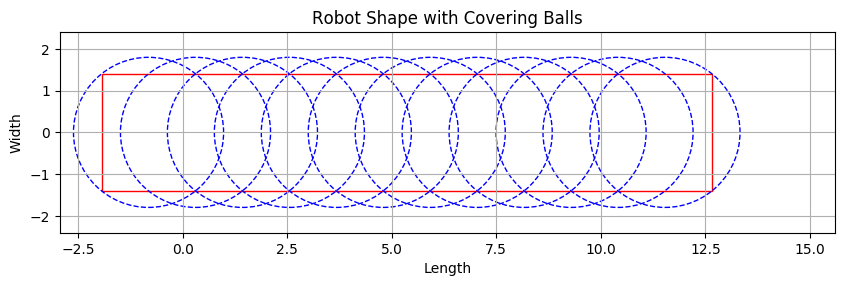

In [9]:
# Create visualization of robot shape approximation
fig, ax = plt.subplots(figsize=(10, 6))

# Plot robot rectangular outline
rectangle = plt.Rectangle((-offset_zoom[0], -rwidth_zoom / 2), 
                        rlength_zoom, rwidth_zoom, 
                        linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rectangle)

# Plot approximating balls
for position in ball_positions:
    circle = plt.Circle(position, ball_radius, 
                       color='b', fill=False, linestyle='--')
    ax.add_artist(circle)

# Set plot parameters
ax.set_xlim(-offset_zoom[0]-1, rlength_zoom + 1)
ax.set_ylim(-rwidth_zoom / 2 - 1, rwidth_zoom / 2 + 1)
ax.set_xlabel('Length')
ax.set_ylabel('Width')
ax.set_title('Robot Shape with Covering Balls')
ax.set_aspect('equal', 'box')
ax.grid(True)

plt.show()

### 3.3 Building the 3D Configuration Space

The robot's configuration space is three-dimensional: $(x, y, θ) ∈ Ω = \mathbb{R}^2 × [0, 2π[$. To handle obstacles in this space, we:

1. Compute the 2D distance transform of obstacles
2. For each ball in our approximation:
   - Transform the distance map based on ball position and orientation
   - Identify configurations where the ball intersects obstacles
3. Combine the obstacle regions for all balls

The obstacles in configuration space $O_Ω$ are defined as:

$$ O_Ω = \bigcup_{i=0}^{N_{balls}-1} \bigcup_{θ ∈[0,2π)} B_{i,θ} $$

where $B_{i,θ}$ represents the obstacle space for the i-th ball at orientation θ:

$$ B_{i,θ} = \{(x, y, θ) ∈ Ω : |(x, y) - (R_θ p_i + (x', y'))| ≤ r_{ball} \text{ for } (x', y') ∈ O_W\} $$

Here, $R_θ$ is the 2D rotation matrix and $O_W$ represents obstacles in the workspace.

#### Distance Transform Calculation

Before constructing the full 3D configuration space, we first compute the distance transform of obstacles in the 2D workspace. The distance transform assigns to each point in free space its distance to the nearest obstacle. 

The distance transform $d(x,y)$ is computed using the Euclidean metric:

$$ d(x,y) = \min_{(x',y') \in O_W} \sqrt{(x-x')^2 + (y-y')^2} $$

where $O_W$ represents the set of obstacle points in the workspace.

In [10]:
# walls_dist_2D represents the distance from each point to the nearest obstacle
walls_dist_2D = ndimage.distance_transform_edt(
    np.logical_not(walls),  # Transform complement of obstacles
    sampling=dx             # Account for grid spacing
)

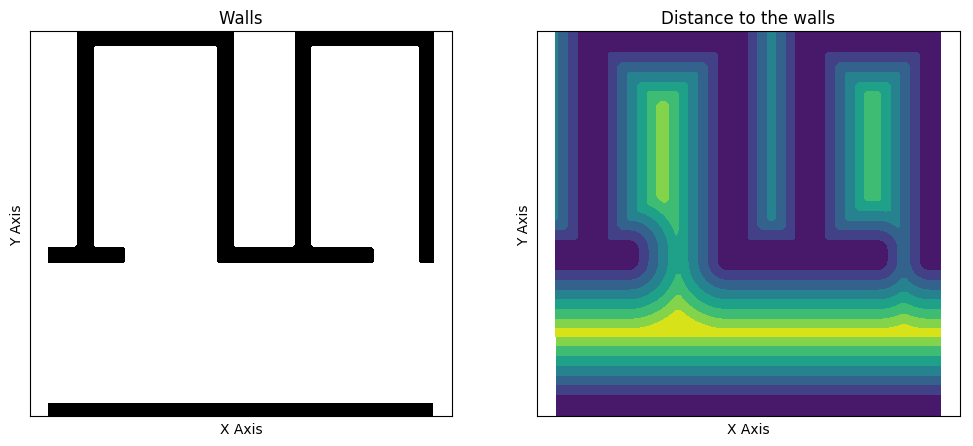

In [11]:

# Create visualization of walls and distance transform
plt.figure(figsize=(12, 5))

# Plot original walls
plt.subplot(1, 2, 1)
plt.axis('equal')
plt.title("Walls")
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.xticks([])  # Hide axis ticks for cleaner visualization
plt.yticks([])
# Plot walls in black and white
plt.contourf(*X, walls, colors=['white', 'black'], levels=1)

# Plot distance transform
plt.subplot(1, 2, 2)
plt.axis('equal')
plt.title("Distance to the walls")
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.xticks([])
plt.yticks([])
# Plot distance transform with default colormap
plt.contourf(*X, walls_dist_2D)

plt.show()

#### Interpretation of the Distance Transform

The visualization shows two complementary views of the environment:

1. **Left Plot (Walls)**:
   - White represents free space
   - Black represents obstacles/walls

2. **Right Plot (Distance Transform)**:
   - Darker colors indicate proximity to obstacles
   - Brighter colors indicate greater distance from obstacles


Next, we'll use this distance transform as a building block for constructing the full 3D configuration space, accounting for the robot's shape and orientation.

#### Construction of the 3D Configuration Space

After computing the 2D distance transform, we now construct the full 3D configuration space by considering all possible orientations of the robot. For each ball in our multi-ball approximation, we need to:

1. Determine how the ball's position changes with robot orientation
2. Check for collisions at each orientation
3. Combine the collision information from all balls

This process translates our 2D obstacle map into a 3D configuration space where each x-y point represents a position in the workspace and the third dimension θ represents all possible robot orientations. True values indicate configurations where at least one ball collides with an obstacle.


The process follows these key steps:
1. Initialize an empty 3D array for accumulating obstacle configurations
2. For each ball in the robot approximation:
   - Compute shifted positions for all orientations
   - Check collision conditions using the distance transform
   - Combine with existing obstacle configurations
3. Convert the accumulated results into a boolean obstacle map

In [12]:
# Initialize 3D array to accumulate obstacle configurations
# Dimensions: (number of angles) x (x positions) x (y positions)
combined_walls = np.zeros((Nθ, Nx, Ny))

# Process each ball in the robot's multi-ball approximation
for i in ball_positions:
    # For each orientation θ, compute where this ball would be positioned
    # -i[0] * unitvec(θ) calculates the ball's offset vector for each orientation
    # ndimage.shift applies this offset to the distance map
    walls3 = [ndimage.shift(walls_dist_2D, 
                          -i[0] * unitvec(θ) / dx,  # Shift vector scaled by grid spacing
                          order=1)                   # Linear interpolation
             for θ in Θ]
    
    # For each orientation, determine collision configurations
    # A collision occurs when either:
    # 1. The original distance map shows a point within ball_radius of an obstacle
    # 2. The shifted distance map shows a point within ball_radius of an obstacle
    walls3 = [np.logical_or(walls_dist_2D <= ball_radius,  # Check original position
                           w <= ball_radius)                # Check shifted position
             for w in walls3]

    # Add these collision configurations to our accumulated map
    # Since we use addition, positions where multiple balls collide
    # will have values > 1, but we'll convert to boolean later
    combined_walls += walls3

# Create final 3D configuration space obstacle map
# - stack combines our angle-specific layers into a 3D array
# - axis=-1 puts the angle dimension last: (x, y, θ)
# - astype(bool) converts to boolean: True where any ball collides
walls3 = np.stack(combined_walls, axis=-1).astype(bool)

#### Distance Transform and Saturation

After constructing the boolean obstacle map in configuration space, we compute two versions of the distance transform:

1. The standard distance transform computes the true distance to obstacles in configuration space. It is useful for precise collision checking and safety margins but values can grow very large in open spaces.

2. The saturated distance transform caps the maximum distance value to prevents excessive deviation in open spaces. Hence in encourages more direct paths when far from obstacles

The saturation threshold is set to the robot length ($R_L$). This choice provides sufficient safety margin for maneuvers and prevents unnecessary deviations in open spaces. However in order to have more visually significant results in this notebook we will divide it by $2$

The mathematical formulation for the saturated distance transform is:

$$ d_{sat}(q) = \min(d(q), R_L) $$

where $d(q)$ is the standard distance transform.

In [13]:
# Compute standard distance transform in configuration space
# Distance along spatial dimensions only (dx, dy) with very large value for θ dimension
walls3_dist = ndimage.distance_transform_edt(
    np.logical_not(walls3),        # Transform complement of obstacles
    (dx, dy, 1e10)                 # Sampling distances for each dimension
)

# Create saturated version for path optimization
# Cap maximum distance at half the robot length to prevent excessive deviation
walls3_dist_saturated = np.minimum(
    ndimage.distance_transform_edt(
        np.logical_not(walls3),
        (dx, dx, 1e10)             # Same sampling as standard transform
    ),
    rlength_zoom*0.5             # Saturation threshold divided by two in this notebook
)

We can then visualize th difference between the standard distance transform and the saturated one by showing a slice of our 3D environement.

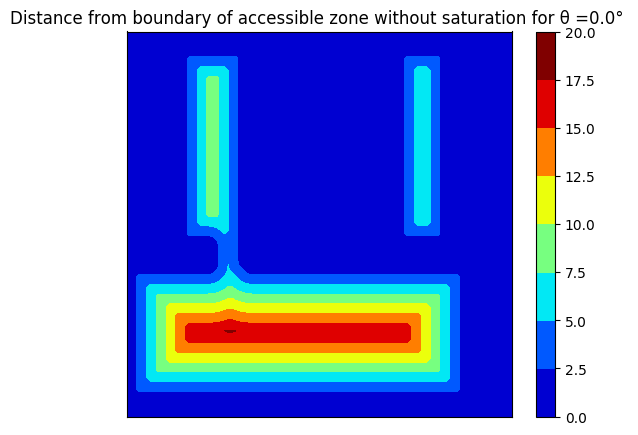

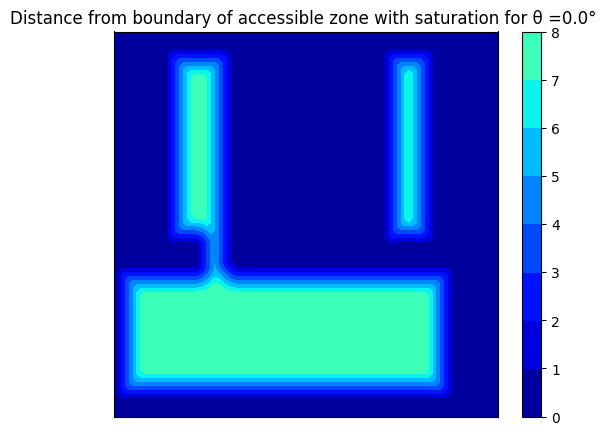

In [14]:
iθ = 0  # Selected orientation index
θ = Θ[iθ]  # Corresponding angle

# Determine combined range for color scale
min_val = min(walls3_dist[:,:,iθ].min(), walls3_dist_saturated[:,:,iθ].min())
max_val = max(walls3_dist[:,:,iθ].max(), walls3_dist_saturated[:,:,iθ].max())

# Plot standard distance transform
plt.figure(figsize=(6.2, 5))
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.title(f"Distance from boundary of accessible zone without saturation for θ ={iθ/Nθ *360}° ")
plt.contourf(*X, walls3_dist[:, :, iθ], vmin=min_val, vmax=max_val, cmap="jet")
plt.colorbar()
plt.show()

# Plot saturated distance transform
plt.figure(figsize=(6.2, 5))
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.title(f"Distance from boundary of accessible zone with saturation for θ ={iθ/Nθ *360}° ")
plt.contourf(*X, walls3_dist_saturated[:, :, iθ], vmin=min_val, vmax=max_val, cmap="jet")
plt.colorbar()
plt.show()

#### Visualizing the Configuration Space

We can examine slices of our 3D configuration space to understand how the obstacle regions change with orientation. For a given angle θ, we can visualize:
- The robot's position at that orientation
- Regions where collisions would occur
- The effective "growth" of obstacles due to the robot's shape


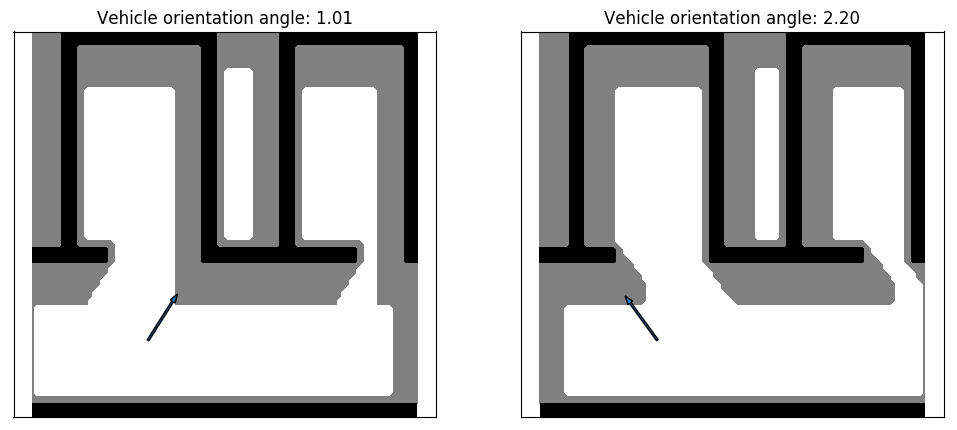

In [15]:
def show_vehicle(x, y, θ, **kwargs):
    """Visualizes vehicle position and orientation using an arrow.
    
    Args:
     - x : X-coordinate of vehicle reference point
     - y : Y-coordinate of vehicle reference point
     - θ : Vehicle orientation angle
        
    The arrow represents:
     - Base point: Center of rear axle
     - Direction: Vehicle's heading
     - Length: Scaled vehicle length
    """
    # Calculate offset based on vehicle orientation
    # Rotation matrix: [cos θ  -sin θ]
    #                 [sin θ   cos θ]
    offset_θ = offset.dot(np.array([[np.cos(θ),np.sin(θ)],
                                   [-np.sin(θ),np.cos(θ)]])) 
    
    # Calculate arrow vector components
    # Arrow starts at rear axle center and extends to front of vehicle
    c, s = rlength_zoom*unitvec(θ) - offset_θ
    
    # Draw arrow with corrected starting point
    plt.arrow(x-offset_θ[0], y-offset_θ[1],  # Start at rear axle
             c, s,                            # Arrow vector
             width=0.5,                       # Arrow width
             length_includes_head=True,       # Arrow length includes head
             **kwargs)                        # Additional styling

# Create visualization figure
plt.figure(figsize=(12, 5))

# Test vehicle position
vehicle_pos = [30, 20]

# Show vehicle at two different orientations
for i, iθ in enumerate([16, 35]):
    θ = Θ[iθ]
    plt.subplot(1, 2, i+1)
    plt.axis('equal')
    
    # Plot configuration space slice
    # - walls.astype(int): Original obstacles (value 1)
    # - walls3[:,:,iθ]: Additional inaccessible space at this orientation
    # Colors: white (accessible), gray (inaccessible at this θ), black (obstacles)
    plt.contourf(*X, 
                 walls.astype(int) + walls3[:,:,iθ],
                 colors=['white','gray','black'],
                 levels=2)
    
    # Show vehicle arrow
    show_vehicle(*vehicle_pos, θ)
    
    # Clean up plot
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Vehicle orientation angle: {θ:.2f}")

plt.show()

## 4. Robot Motion Modeling

### 4.1 Four-Wheel Steering Kinematics

The forklift's motion is governed by a kinematic model that accounts for both front and rear steering capabilities. For a configuration $q = (x, y, θ)$, the kinematic equations are:

$$ \begin{cases}
\dot{x} = v \cos(θ + ψ) \\
\dot{y} = v \sin(θ + ψ) \\
\dot{θ} = v \frac{\tan(ϕ) - \tan(ψ)}{L}
\end{cases} $$

where: $v$ is the velocity, $ψ$ is the rear steering angle, $ϕ$ is the front steering angle and $L$ is the wheelbase

The steering angles are bounded by their maximum values:
$$ |ψ| ≤ ψ_{max}, \quad |ϕ| ≤ ϕ_{max} $$


In [16]:
# Define steering limits
ψ_max = 0.5  # Maximum rear steering angle
ϕ_max = 0.5  # Maximum front steering angle

def Four_Wheel_Steering_kinematic(q, ψ, ϕ, τ, wheelbase):
    """Applies 4WS kinematic model to compute next configuration.
    
    Args:
     - q: Current configuration (x, y, θ)
        ψ: Rear steering angle
        ϕ: Front steering angle
        τ: Time step / velocity
        wheelbase: Distance between front and rear axles
    
    Returns:
        Next configuration q1 = (x1, y1, θ1)
    """
    q1 = [0, 0, 0]
    
    # Position update
    q1[0] = q[0] + τ * np.cos(q[2] + ψ)  # x component
    q1[1] = q[1] + τ * np.sin(q[2] + ψ)  # y component
    
    # Orientation update
    q1[2] = q[2] + τ * (np.tan(ϕ) - np.tan(ψ)) / wheelbase
    
    return q1

#### Tissot's Indicatrix for the 4WS Model

To understand the local behavior of our four-wheel steering system, we can visualize Tissot's indicatrix in the configuration space. This represents the set of configurations reachable in unit time from a given starting point.

For our 4WS model, we examine paths generated by combinations of extreme steering angles: $±ϕ_{max}$ and $±ψ_{max}$

The blue surfaces represent the envelope of reachable configurations, while black lines show individual paths for each extreme steering combinations.

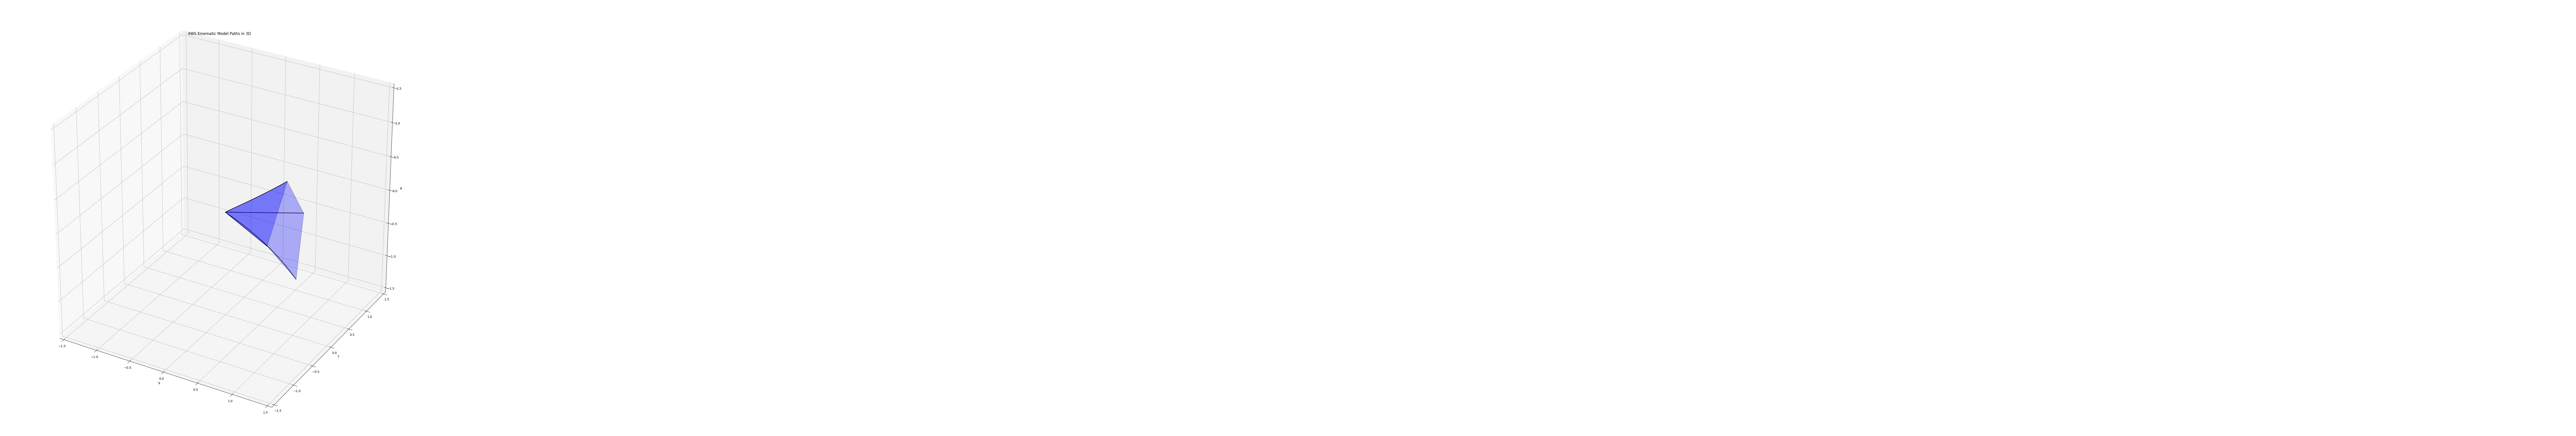

In [17]:
# Define extreme steering angles
steering_back = [ϕ_max, -ϕ_max]  # Front steering extremes
steering_front = [ψ_max, -ψ_max]  # Rear steering extremes

# Time step parameters
τ = 0.1       # Step size
length = 1    # Total path length
paths = []    # Store all generated paths

# Calculate paths for all combinations of extreme steering angles
for ϕ in steering_back:
    for ψ in steering_front:
        q = [0, 0, 0]  # Starting configuration
        path = [q]
        
        # Generate path points
        for i in range(int(length/τ)):
            q = Four_Wheel_Steering_kinematic(q, ψ, ϕ, τ, wheelbase)
            path.append(q)
        paths.append(path)

# Create 3D visualization
fig = plt.figure(figsize=(25, 25), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

# Create boundary surfaces between paths
for i in range(0, len(paths)-1, 2):
    # Extract path edges
    edge1 = np.array(paths[i % len(paths)])
    edge2 = np.array(paths[(i+1) % len(paths)])
    
    # Create vertices for surface
    vertices = np.column_stack([edge1[:,0], edge1[:,1], edge1[:,2]])
    vertices = np.row_stack([vertices, 
                           np.flip(np.column_stack([edge2[:,0], 
                                                  edge2[:,1], 
                                                  edge2[:,2]]), axis=0)])
    
    # Create and add surface
    poly = Poly3DCollection([vertices], alpha=0.3)
    poly.set_facecolor('blue')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)

# Create additional connecting surfaces
for i in range(0, len(paths), 3):
    edge1 = np.array(paths[i % len(paths)])
    edge2 = np.array(paths[(i + 2) % len(paths)])
    
    vertices = np.column_stack([edge1[:,0], edge1[:,1], edge1[:,2]])
    vertices = np.row_stack([vertices, 
                           np.flip(np.column_stack([edge2[:,0], 
                                                  edge2[:,1], 
                                                  edge2[:,2]]), axis=0)])
    
    poly = Poly3DCollection([vertices], alpha=0.3)
    poly.set_facecolor('blue')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)

# Plot individual paths
for path in paths:
    x = [point[0] for point in path]
    y = [point[1] for point in path]
    z = [point[2] for point in path]
    ax.plot(x, y, z, c='k')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('θ')
ax.set_title('4WS Kinematic Model Paths in 3D')

plt.show()

**Note:** For better interactive visualization of the 3D plot, it's recommended to run this code with `%matplotlib` magic command in Jupyter notebook. 


This visualization helps understand the enhanced maneuverability provided by four-wheel steering compared to traditional car-like vehicles in the configuration space.

### 4.2 Basic Motion Control

Before introducing the full state system, we first implement basic motion controls that demonstrate the core capabilities of a 4WS vehicle. We implement a forward motion only, backward motion only and an omnidirectional motion (combined forward and backward).

The mathematical model for each control vector follows the form:

$$\begin{cases} 
\pm \cos(θ \pm ψ_{max}) \\
\pm \sin(θ \pm ψ_{max}) \\
\pm (\tan(\pm ϕ_{max}) - \tan(\pm ψ_{max}))/L
\end{cases} $$

where the ± indicates forward or backward motion and steering right or left

In [18]:
def Four_WS_back(θ, wheel_base, ψ_max=0.5, ϕ_max=0.5):
    """Control vectors for 4WS vehicle with only backward motion.
    
    Args:
        θ: Current orientation
        wheel_base: Vehicle wheelbase
        ψ_max: Maximum rear steering angle
        ϕ_max: Maximum front steering angle
        
    Returns:
        Array of control vectors for backward motion
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    return xp.array([
        # Each vector contains (x_dot, y_dot, θ_dot)
        (-np.cos(Θ+ψ_max), -np.sin(Θ+ψ_max), -( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ-ψ_max), -np.sin(Θ-ψ_max), -(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ-ψ_max), -np.sin(Θ-ψ_max), -( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ+ψ_max), -np.sin(Θ+ψ_max), -(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ])[...,np.newaxis]

def Four_WS_front(θ, wheel_base, ψ_max=0.5, ϕ_max=0.5):
    """Control vectors for 4WS vehicle with only forward motion.
    
    Args:
        θ: Current orientation
        wheel_base: Vehicle wheelbase
        ψ_max: Maximum rear steering angle
        ϕ_max: Maximum front steering angle
        
    Returns:
        Array of control vectors for forward motion
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    return xp.array([
        (np.cos(Θ+ψ_max), np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max), np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max), np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ+ψ_max), np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ])[...,np.newaxis]

def Four_WS_omni(θ, wheel_base, ψ_max=0.5, ϕ_max=0.5):
    """Control vectors for 4WS vehicle with both forward and backward motion.
    
    Args:
        θ: Current orientation
        wheel_base: Vehicle wheelbase
        ψ_max: Maximum rear steering angle
        ϕ_max: Maximum front steering angle
        
    Returns:
        Array of control vectors for omnidirectional motion
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    
    # Forward motion vectors
    forward_controls = [
        (np.cos(Θ+ψ_max), np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max), np.sin(Θ-ψ_max), (-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max), np.sin(Θ-ψ_max), ( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ+ψ_max), np.sin(Θ+ψ_max), (-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ]
    
    # Backward motion vectors (negative of forward)
    backward_controls = [
        (-np.cos(Θ+ψ_max), -np.sin(Θ+ψ_max),-( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ-ψ_max), -np.sin(Θ-ψ_max),-(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ-ψ_max), -np.sin(Θ-ψ_max),-( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ+ψ_max), -np.sin(Θ+ψ_max),-(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ]
    
    # Combine forward and backward controls
    return xp.array(forward_controls + backward_controls)[...,np.newaxis]

### 4.3 Complex State System

Building on the basic state system, we implement a more sophisticated approach that better matches human driving behavior and operational efficiency. This system comprises:

1. Forward Navigation State : 
it uses simplified 2WS controls with higher speed capability compare to maneuvre states. Straightforward movements is encouraged with higher norm.

2. Forward Maneuvering State :
capable of the full 4WS forward agility but has lower speed so should only be used if necessary.

3. Backward Maneuvering State :
is the mirror of forward maneuvering

4. Backward Navigation State : 
is the mirror of forward navigation but with speed potentially reduced 


In [19]:
def Four_WS_complex_state(θ, wheel_base, rev_ratio=1, ϕ_max=0.5, ψ_max=0.5):
    """Implements state-based control scheme for 4WS vehicle.
    
    States:
    1. Forward navigation - Basic 2WS capabilities
    2. Maneuvering forward- 4WS capabilities
    3. Maneuvering backward- 4WS capabilities
    4. Backward navigation - Reverse motion
    
    Args:
        θ: Current orientation
        wheel_base: Vehicle wheelbase
        rev_ratio: Speed ratio for reverse motion (default=1)
        ϕ_max: Maximum front steering angle (default=0.5)
        ψ_max: Maximum rear steering angle (default=0.5)
    
    Returns:
        Array of control vectors for each state
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    
    # Forward navigation state - higher speed, limited steering
    nav_forward = 1.5*xp.array([
        (np.cos(θ),np.sin(θ),np.tan(ϕ_max) / (wheel_base * one)),    # Left turn
        (np.cos(θ),np.sin(θ),np.tan(-ϕ_max) / (wheel_base * one)),   # Right turn
        (2*np.cos(Θ),2*np.sin(Θ),zero),                              # Straight
        (zero,zero,zero),                                             # null vector so that each states as the same number of vectors
    ])
    
    # Maneuvering states controls (4WS capabilities and lower speed)
    #forward maneuver motions
    maneuver_forward = 0.5*xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one)
    ])
    # backward motions, mirror of forward maneuver motions
    maneuver_backward = - maneuver_forward
    
    # Backward navigation state - scaled version of forward
    nav_backward = -rev_ratio*nav_forward
    
    return np.stack((nav_forward, maneuver_forward, maneuver_backward, nav_backward), axis=-1)

#### State Transition Costs
State transitions are governed by a cost matrix $T(s, s')$ where:
- $T(s, s)$ = 0 (staying in current state)
- $T(s, s')$ > 0 (cost of switching states)

The system favors maintaining the current state when possible, transitioning only when necessary for optimal path planning. This produces more natural and predictable vehicle behavior.

The transition cost matrix is structured as:

$$ T = \begin{bmatrix} 
0 & k_2 & k_2 & k_1 \\
k_2 & 0 & 1 & k_2 \\
k_2 & 1 & 0 & k_2 \\
k_1 & k_2 & k_2 & 0
\end{bmatrix} $$

where:
- $k_1$ represents the cost of switching between forward and backward states
- $k_2$ represents the cost of entering or leaving the maneuvering states

The matrix T and the value of $k_1$ and $k_2$ are defined later

The 2WS state system represents a more constrained version of vehicle control where only the front wheels can steer ($ψ_{max} = 0$). We implement it to show the comparaison between the two model and the versatility of our method

In [20]:
def Two_WS_complex_state(θ, wheel_base, rev_ratio=1, ϕ_max=0.5):
    """Implements state-based control scheme for 4WS vehicle.
    
    States:
    1. Forward navigation - Basic 2WS capabilities
    2. Maneuvering forward- 4WS capabilities
    3. Maneuvering backward- 4WS capabilities
    4. Backward navigation - Reverse motion
    
    Args:
        θ: Current orientation
        wheel_base: Vehicle wheelbase
        rev_ratio: Speed ratio for reverse motion (default=1)
        ϕ_max: Maximum front steering angle (default=0.5)
    
    Returns:
        Array of control vectors for each state
    """
    
    ψ_max=0. #Maximum rear steering angle is always 0 for 2WS
    
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    
    # Forward navigation state - higher speed, limited steering
    nav_forward = 1.5*xp.array([
        (np.cos(θ),np.sin(θ),np.tan(ϕ_max) / (wheel_base * one)),    # Left turn
        (np.cos(θ),np.sin(θ),np.tan(-ϕ_max) / (wheel_base * one)),   # Right turn
        (2*np.cos(Θ),2*np.sin(Θ),zero),                              # Straight
        (zero,zero,zero),                                             # null vector so that each states as the same number of vectors
    ])
    
    # Maneuvering states controls (4WS capabilities and lower speed)
    #forward maneuver motions
    maneuver_forward = 0.5*xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one),
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one)
    ])
    # backward motions, mirror of forward maneuver motions
    maneuver_backward = - maneuver_forward
    
    # Backward navigation state - scaled version of forward
    nav_backward = -rev_ratio*nav_forward
    
    return np.stack((nav_forward, maneuver_forward, maneuver_backward, nav_backward), axis=-1)

## 5. Path Planning Implementation

### 5.1 Fast Marching Method

The core of our path planning approach uses the Hamiltonian Fast Marching Method (HFM) adapted for state-based systems. The method solves a modified eikonal equation that incorporates both the vehicle's kinematic constraints and state transitions.

#### Mathematical Formulation

The value function $U(q,s)$ satisfies:

$$ \max\left(\max_i(\langle\nabla U(q,s), \dot{e}_{is}\rangle), \max_{s' \neq s}\frac{1}{T(s,s')}\right)^2 = \frac{1}{2}c(q)^2 $$

where:
- $\dot{e}_{is}$ represents the control vectors in state $s$
- $T(s,s')$ is the state transition cost
- $c(q)$ is the local cost function incorporating obstacles

The local cost function combines base movement cost (typically 1) and obstacle proximity penalty

This formulation allows simultaneous optimization of the path length, the clearance from obstacles, state transition efficiency and kinematic feasibility

### 5.2 Solver Initialization

The Fast Marching solver is initialized using a dictionary-based configuration system that specifies all necessary parameters for path planning. 

In [21]:
hfmIn=None
hfmOut=None

In [22]:
# Initialize the HFM solver
hfmIn0 = Eikonal.dictIn({
    'model': 'DubinsState4',  # Model type for 4WS vehicle
    
    # Starting configuration (x, y, θ, state)
    'seed': [30, 70, np.pi/2, 0],
    
    # Target configurations
    'tips': [
        [90, 7, np.pi, 0],   # End state 0 
        [90, 80, np.pi, 0],  # End state 0
        [5, 20, 0, 0]        # End state 0
    ],
    
    # Domain origin and grid scales
    'origin': (0, 0, 0, -0.5),
    'gridScales': (dx, dy, 2*np.pi/Nθ, 1),
    
    # Boundary conditions and domain topology
    'periodic': [False, False, True, False],  # R² × S¹ × A
    
    # Solver options
    'exportActiveNeighs': True,  # For control extraction
    'exportValues': True,        # For visualization
    'verbosity': 1              # Output level
})

### 5.3 Running the Path Planning Solver

The `run_controls` function serves as the main interface to the path planning system.

The function returns both the solver input configuration and output, including computed geodesics (optimal paths). It also plot the results

In [23]:
def run_controls(hfmIn, controls, fm2=1., saturation=0, state_transition_costs=5, verbosity=1, **kwargs):
    """Runs the eikonal solver with state-based controls and obstacle avoidance.
    
    Args:
        hfmIn: Input dictionary for FMM solver
        controls: State-dependent control vectors
        fm2: Weight for obstacle proximity penalty
        saturation: Use saturated distance for open spaces
        state_transition_costs: Base cost for state transitions
        verbosity: Output detail level
    
    Returns:
        hfmIn: Updated input dictionary
        hfmOut: Solver output including geodesics
    """
    # Configure control system
    hfmIn['controls'] = controls
    nstates = hfmIn['controls'].shape[-1]
    hfmIn['state_transition_costs'] = state_transition_costs * np.ones((nstates, nstates))
    hfmIn['dims'] = (Nx, Ny, Nθ, nstates)
    
    # Define speed/cost function incorporating obstacles
    if saturation:
        # Use saturated distance to avoid deviation in open spaces
        hfmIn['speed'] = np.broadcast_to(1 + fm2 * xp.array(walls3_dist_saturated)[:, :, :, np.newaxis], hfmIn.shape)
    else:
        # Use full distance transform
        hfmIn['speed'] = np.broadcast_to(1 + fm2 * xp.array(walls3_dist)[:, :, :, np.newaxis], hfmIn.shape)
    
    # Set obstacle regions
    hfmIn['walls'] = np.broadcast_to(xp.array(walls3[:, :, :, np.newaxis]), hfmIn.shape)
    
    # Update parameters and run solver
    hfmIn.update(verbosity=verbosity, **kwargs)
    hfmOut = hfmIn.Run()
    
    
    # Visualization of results
    # Set equal aspect ratio for visualization
    plt.axis('equal')
    
    # Plot environment obstacles using binary colormap
    plt.pcolormesh(*X, walls, cmap='binary')
    
    # Define colors for multiple trajectories
    c = ['tab:blue','tab:orange','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    
    # Draw starting vehicle configuration in blue
    show_vehicle(*hfmIn0['seed'][:3].get(), color='blue')
    
    # Draw target configurations in red with numeric labels
    for i, tip in enumerate(hfmIn0['tips']):
        show_vehicle(*tip[:3].get(), color='red')
        plt.text(*tip[:2], i)
    
    # Plot trajectories and vehicle configurations along paths
    k = 0  # Color index
    for i, geo in enumerate(hfmOut['geodesics']):
        # Plot rear axle trajectory
        plt.plot(geo[0], geo[1], label=f"rear {i}", c=c[k])
        
        # Plot front axle trajectory (dotted line)
        plt.plot(geo[0] + wheelbase_zoom * np.cos(geo[2]), geo[1] + wheelbase_zoom * np.sin(geo[2]), linestyle=':', label=f"front {i}")
        
        # Adjust orientation for vehicle visualization
        geo[2] = geo[2] + np.pi
        
        # Draw vehicle configurations along trajectory
        draw_bot(geo, 10, zoom_factor, np.array([rlength, rwidth]), offset, wheelbase,colors=['g',c[k],'r'])
        
        # Cycle through colors for multiple trajectories
        k += 1
        k = k % len(c)
    
    return hfmIn, hfmOut

## 6. Results

### 6.1 Comparative results for simple motion control and varying cost function

We now analyze three fundamental motion strategies for the 4WS forklift:
1. Backward-only motion
2. Forward-only motion  
3. Omnidirectional motion (combining both forward and backward capabilities)

And we analyse the impact of three cost function : 
1. Cost dependent to the distance to the closest obstacle
2. Cost dependent to the saturated distance to the closest obstacle
3. Unitary cost

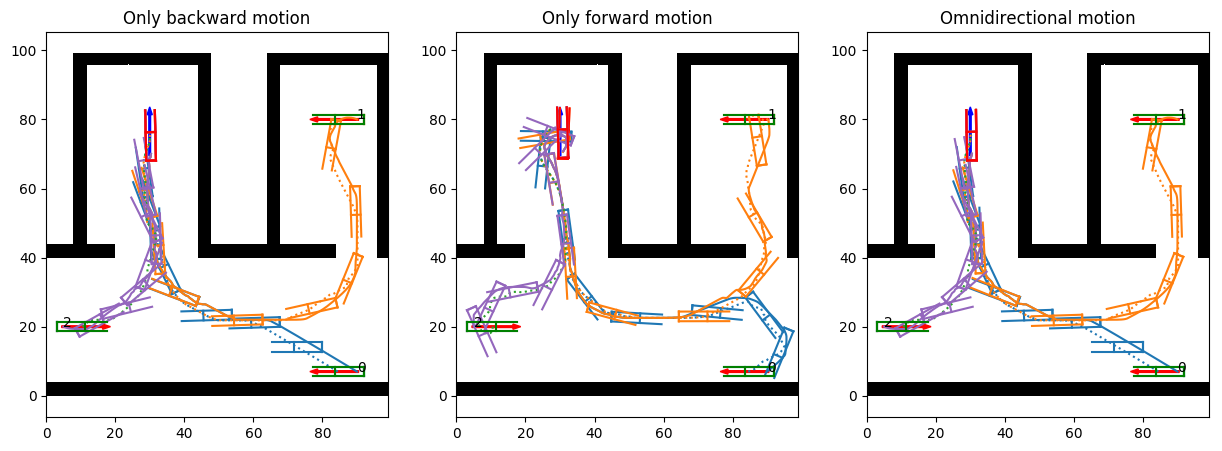

In [24]:
# Create comparative visualization of different motion strategies
plt.figure(figsize=(15,5))

# Test backward-only motion
plt.subplot(1,3,1)
plt.title("Only backward motion")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_back(Θ, wheelbase_zoom),
                            fm2=1,  # Enable obstacle cost weighting
                            verbosity=0)

# Test forward-only motion
plt.subplot(1,3,2)
plt.title("Only forward motion")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_front(Θ, wheelbase_zoom),
                            fm2=1,
                            verbosity=0)

# Test omnidirectional motion
plt.subplot(1,3,3)
plt.title("Omnidirectional motion")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_omni(Θ, wheelbase_zoom),
                            fm2=1,
                            verbosity=0)

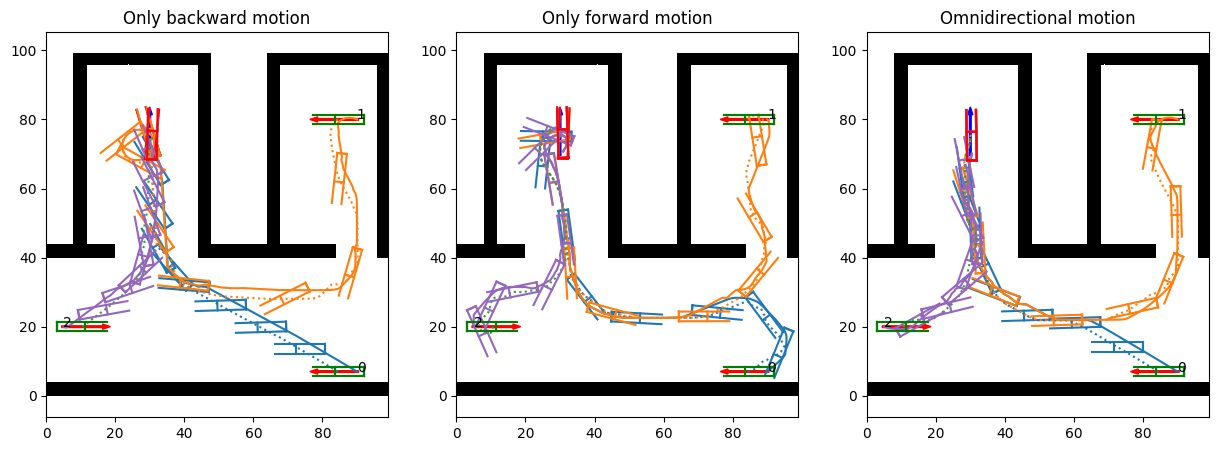

In [25]:
#Compare strategies with saturated environmental cost considerations
plt.figure(figsize=(15,5))

# Test backward-only motion
plt.subplot(1,3,1)
plt.title("Only backward motion")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_back(Θ, wheelbase_zoom),
                            fm2=1,  # Enable obstacle cost weighting
                            saturation=1, # Enable staurated cost
                            verbosity=0)

# Test forward-only motion
plt.subplot(1,3,2)
plt.title("Only forward motion")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_front(Θ, wheelbase_zoom),
                            fm2=1,
                            verbosity=0)

# Test omnidirectional motion
plt.subplot(1,3,3)
plt.title("Omnidirectional motion")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_omni(Θ, wheelbase_zoom),
                            fm2=1,
                            verbosity=0)

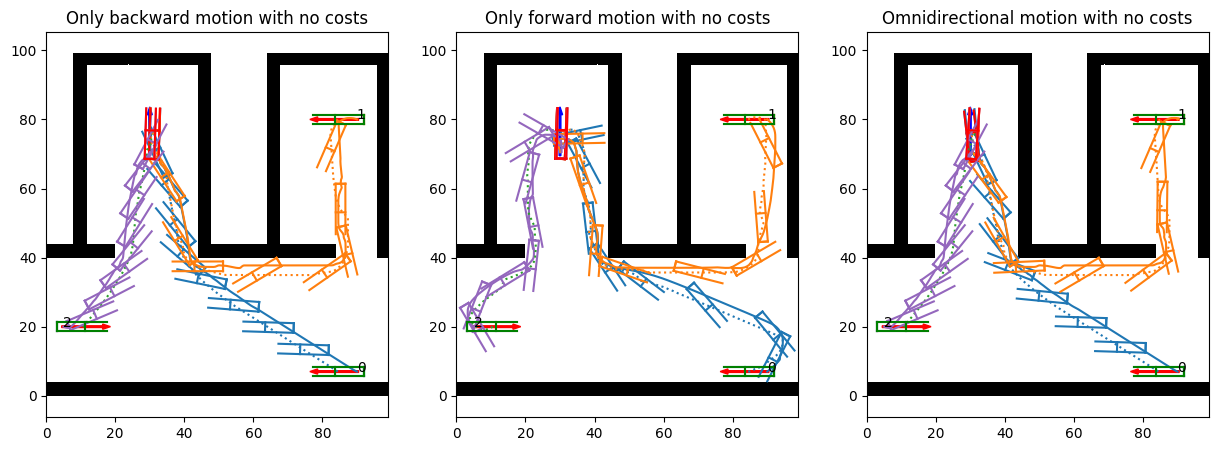

In [26]:
# Compare strategies without environmental cost considerations
plt.figure(figsize=(15,5)) 
plt.subplot(1,3,1); plt.title("Only backward motion with no costs")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_back(Θ,wheelbase_zoom),
                            fm2=0, # Disable  obstacle cost weighting
                            saturation=0,
                            verbosity=0)

plt.subplot(1,3,2); plt.title("Only forward motion with no costs")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_front(Θ,wheelbase_zoom),
                            fm2=0,
                            saturation=0,
                            verbosity=0)

plt.subplot(1,3,3); plt.title("Omnidirectional motion with no costs")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_omni(Θ,wheelbase_zoom),
                            fm2=0,
                            saturation=0,
                            verbosity=0)

We can see how the cost "pushes" the path further away from the obstacles.

### 6.2 Comparative results for complex motion control with various settings


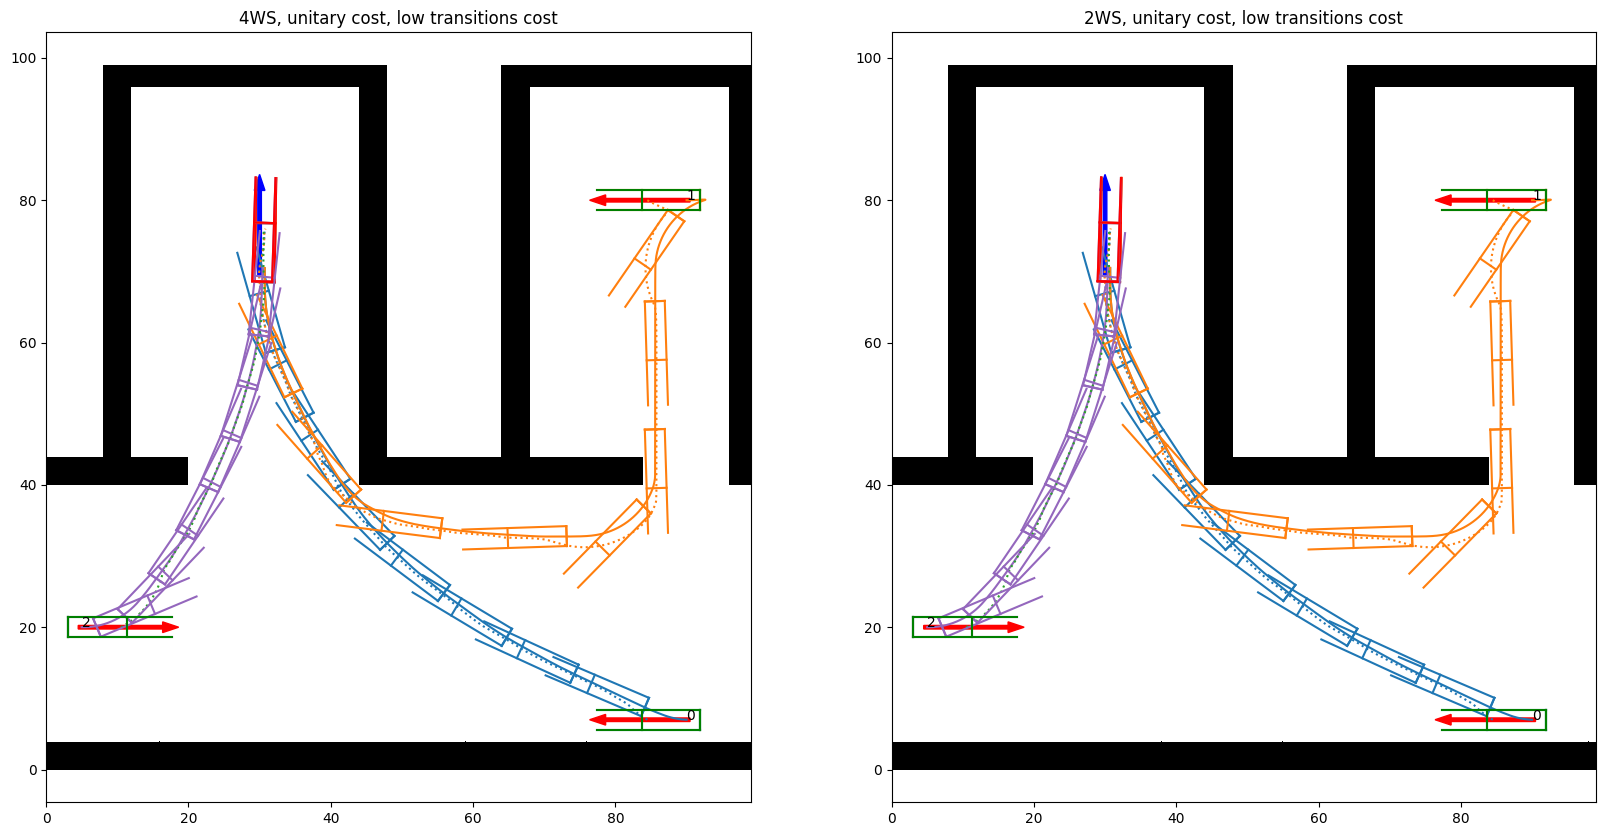

In [27]:
# Define state transition costs
k1 = 1  # Base transition cost
k2 = 1*k1  # Inter-mode transition cost

# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, unitary cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=0,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, unitary cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=0,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

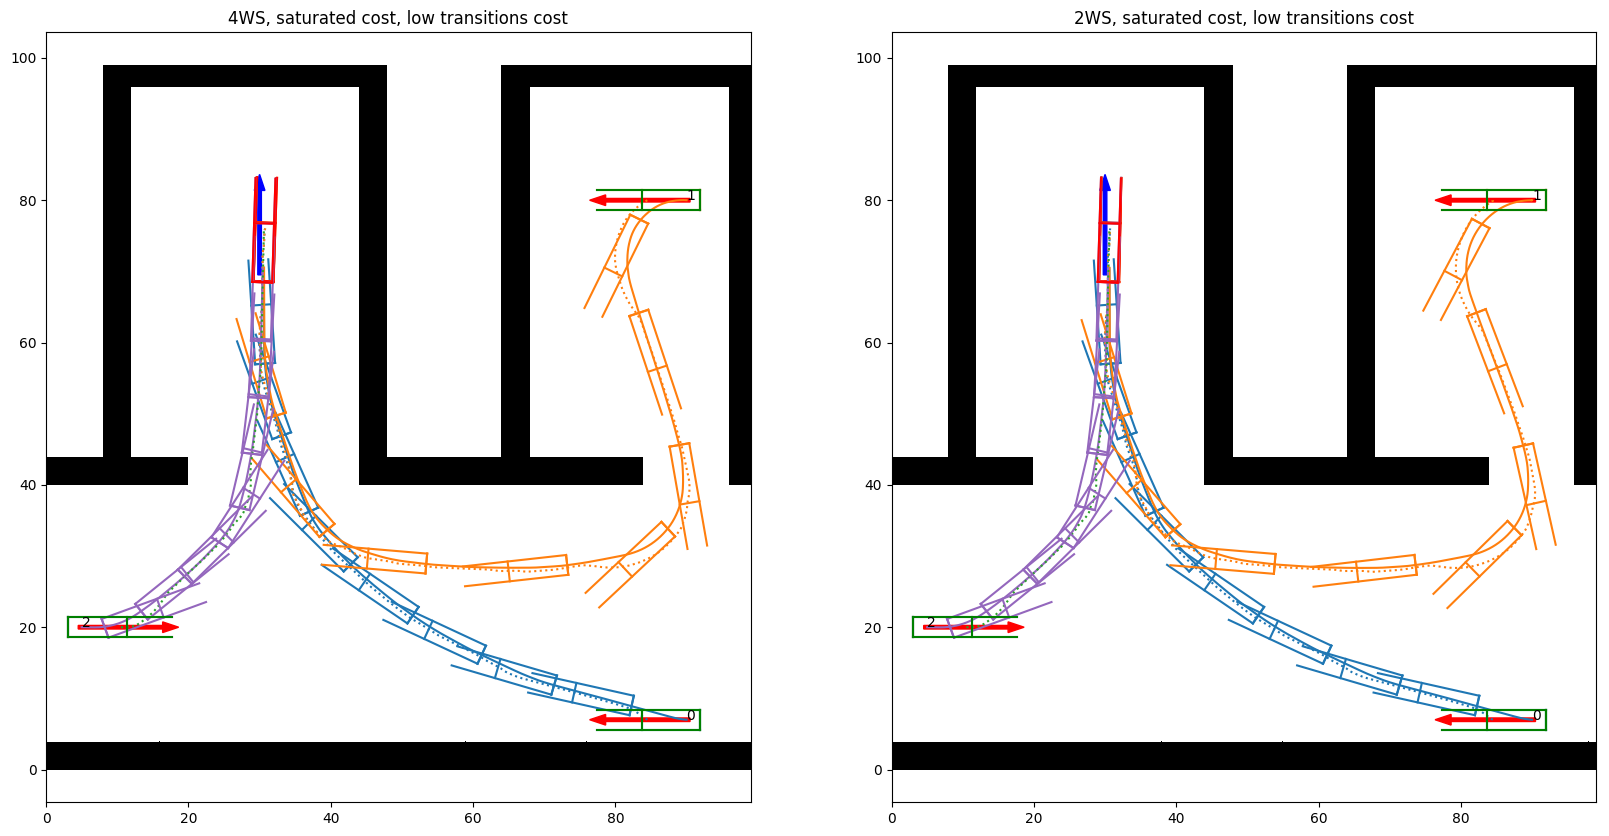

In [28]:
k1 = 1
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

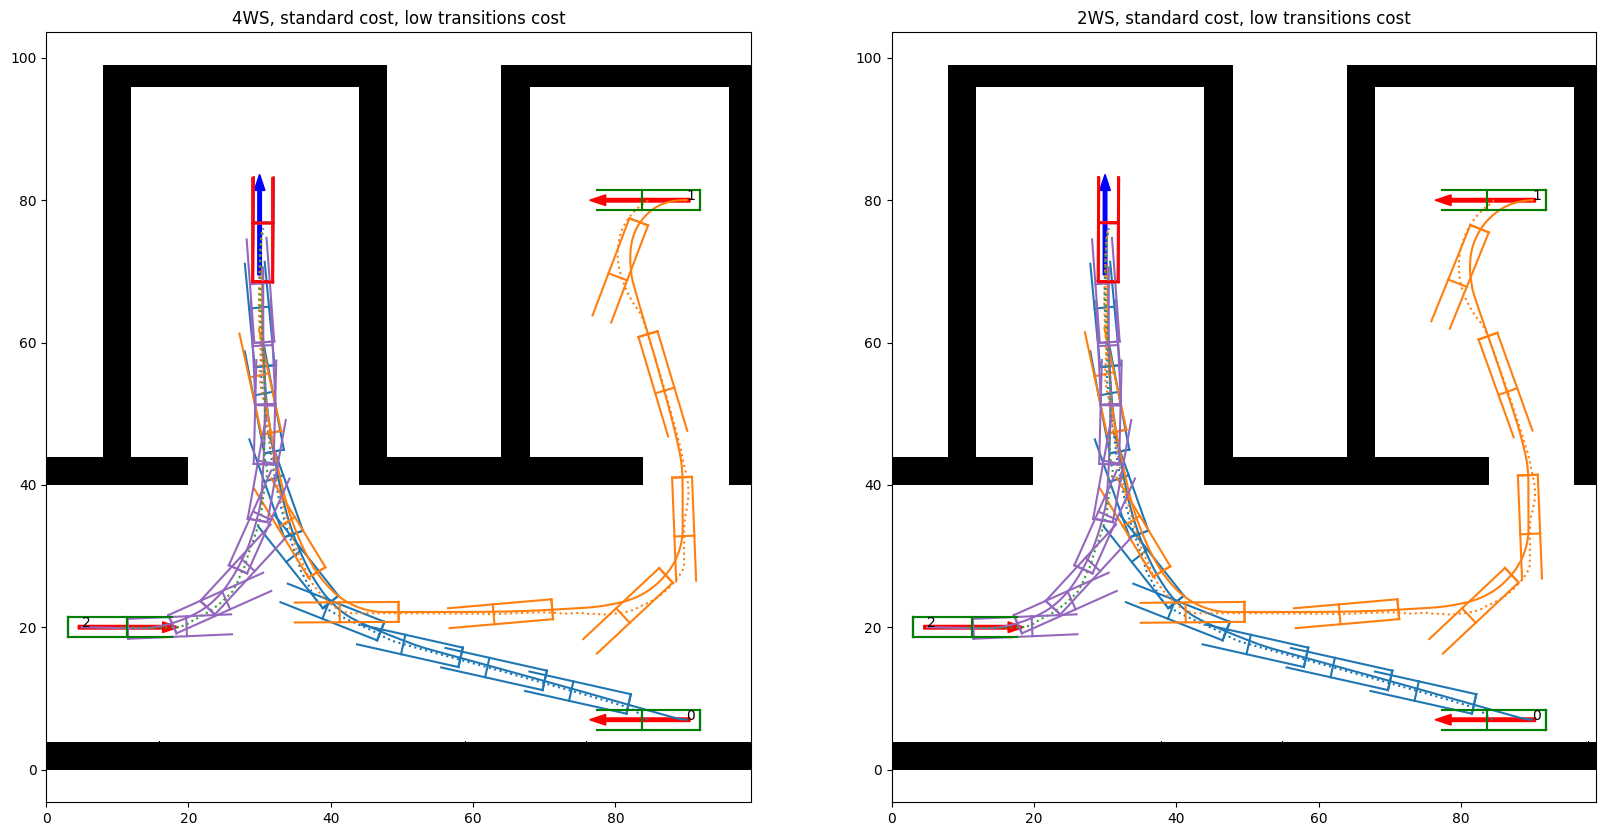

In [29]:
k1 = 1
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

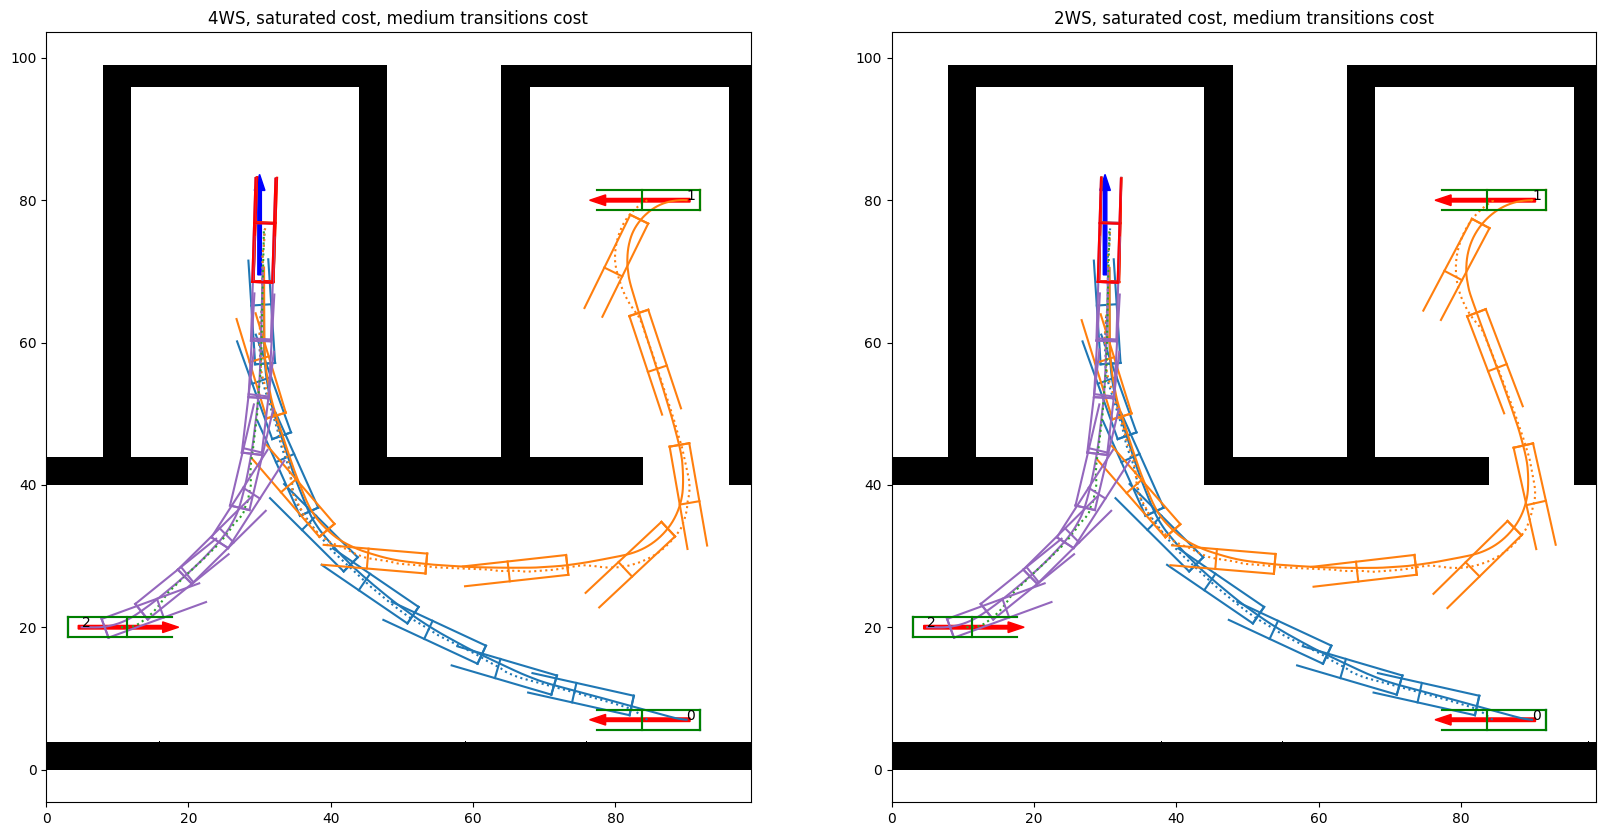

In [30]:
k1 = 1
k2 = 50*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, medium transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, medium transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

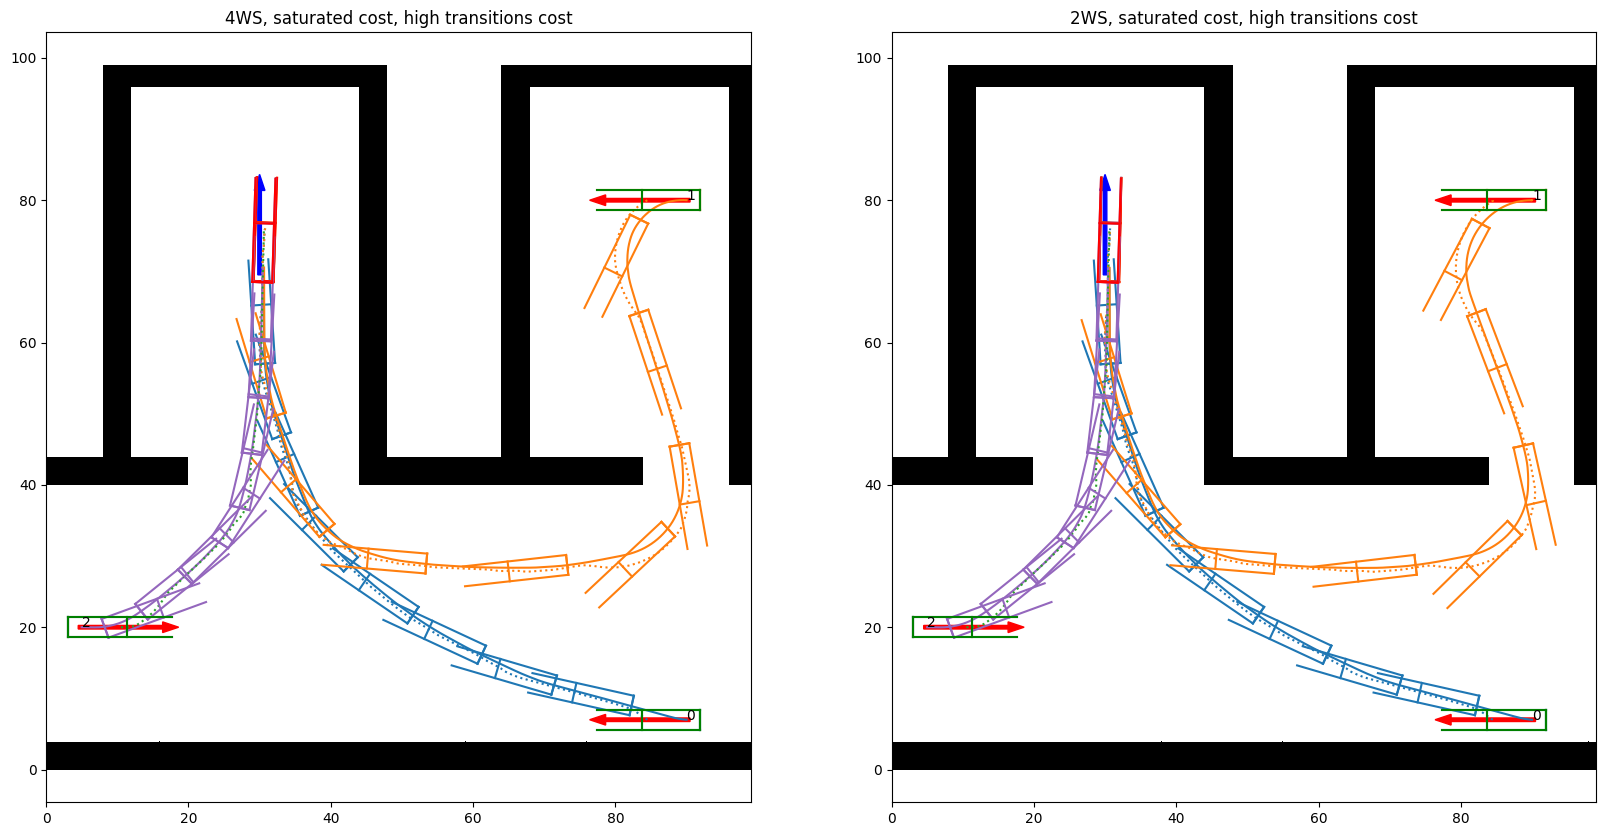

In [31]:
k1 = 200
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, high transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, high transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

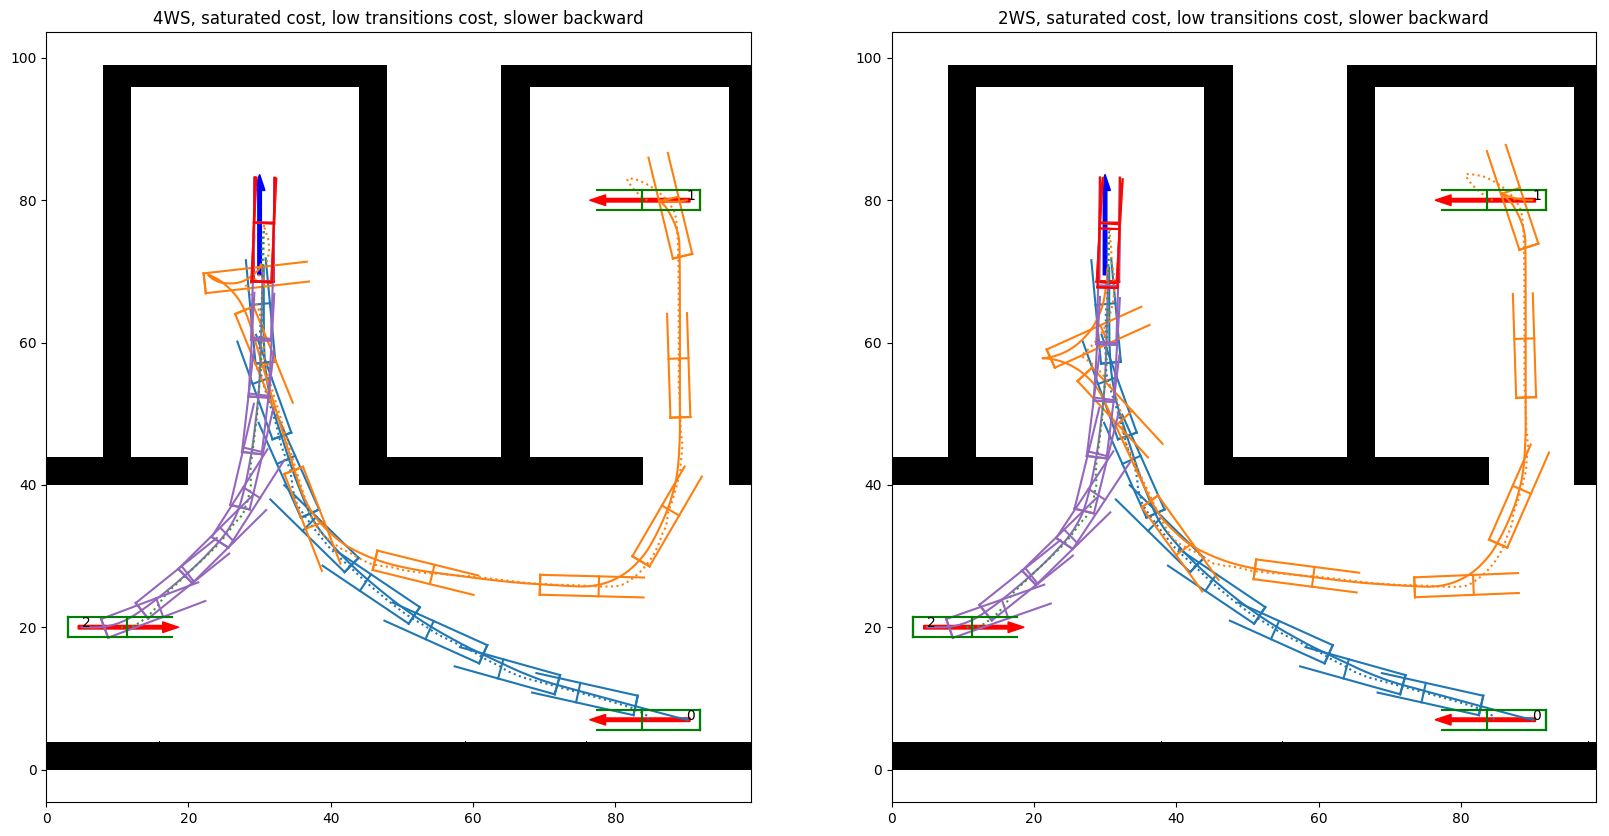

In [32]:
k1 = 1
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, low transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, low transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

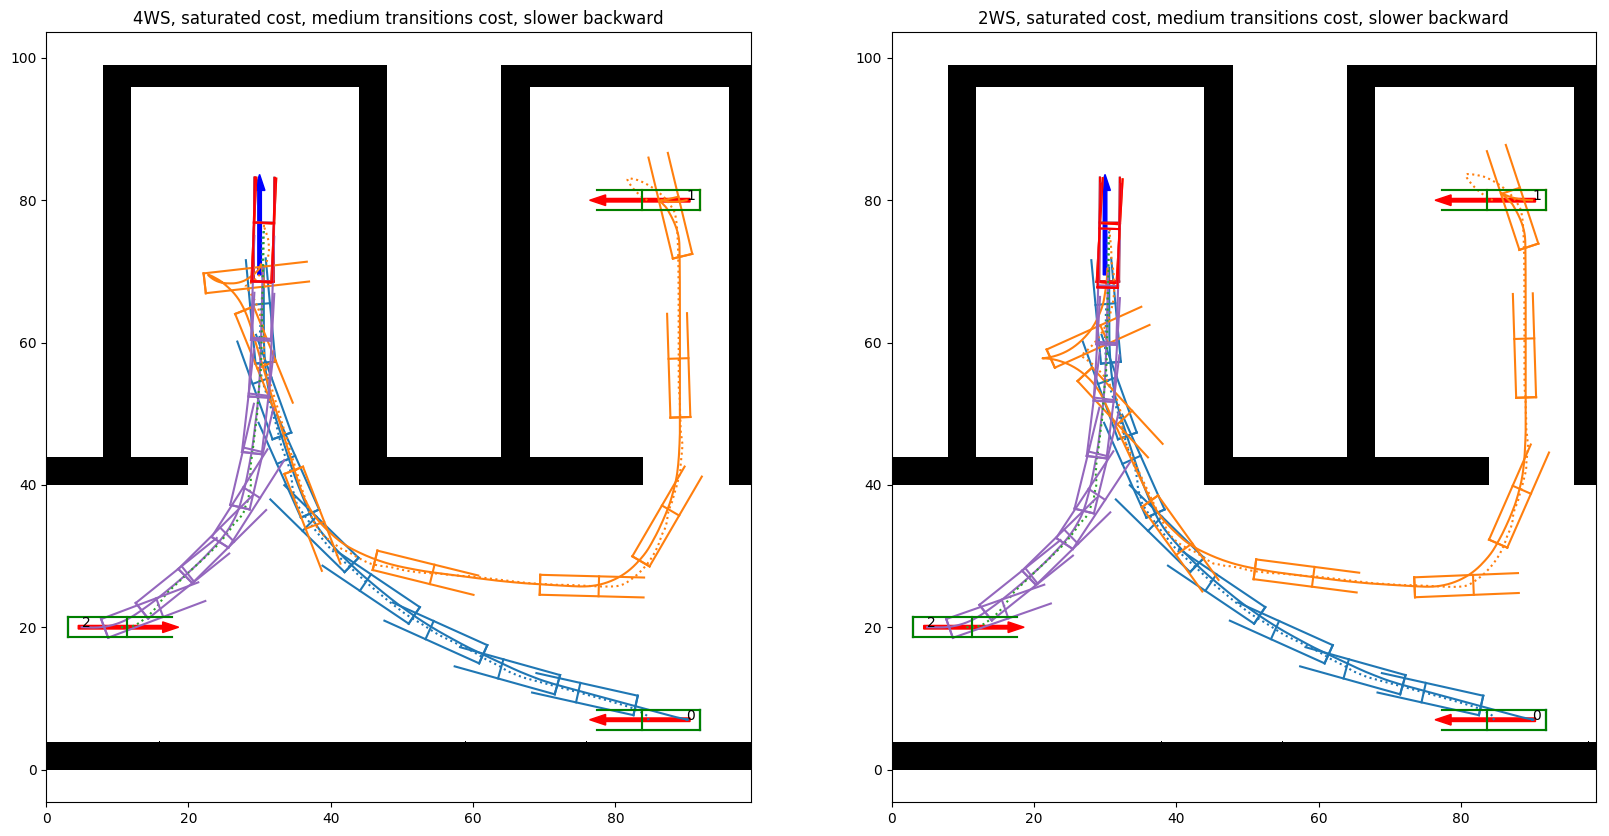

In [33]:
k1 = 1
k2 = 50*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, medium transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, medium transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

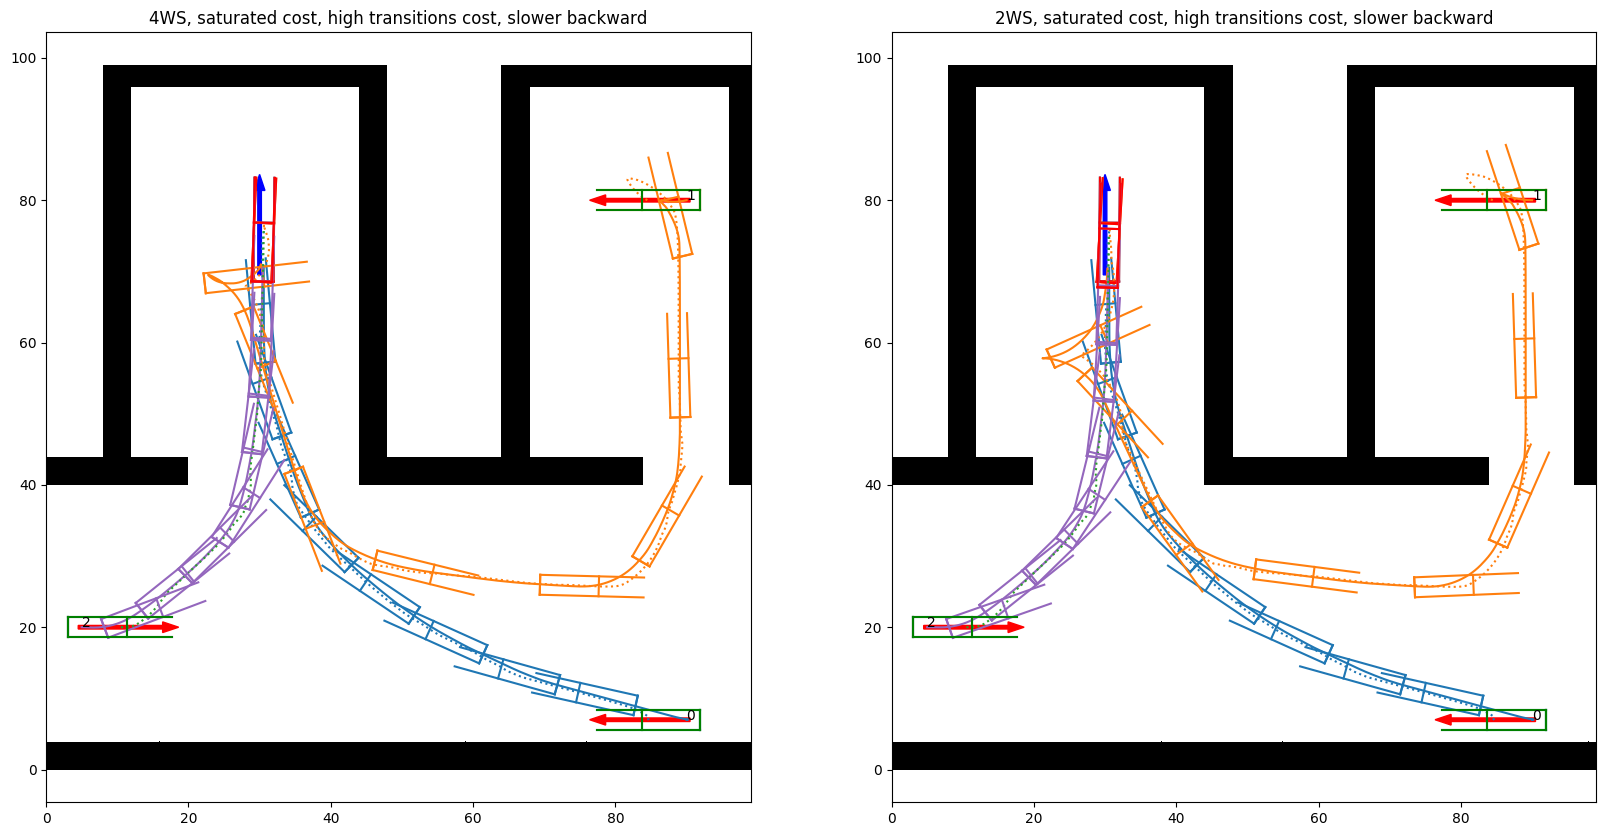

In [34]:
k1 = 200
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, high transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, high transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

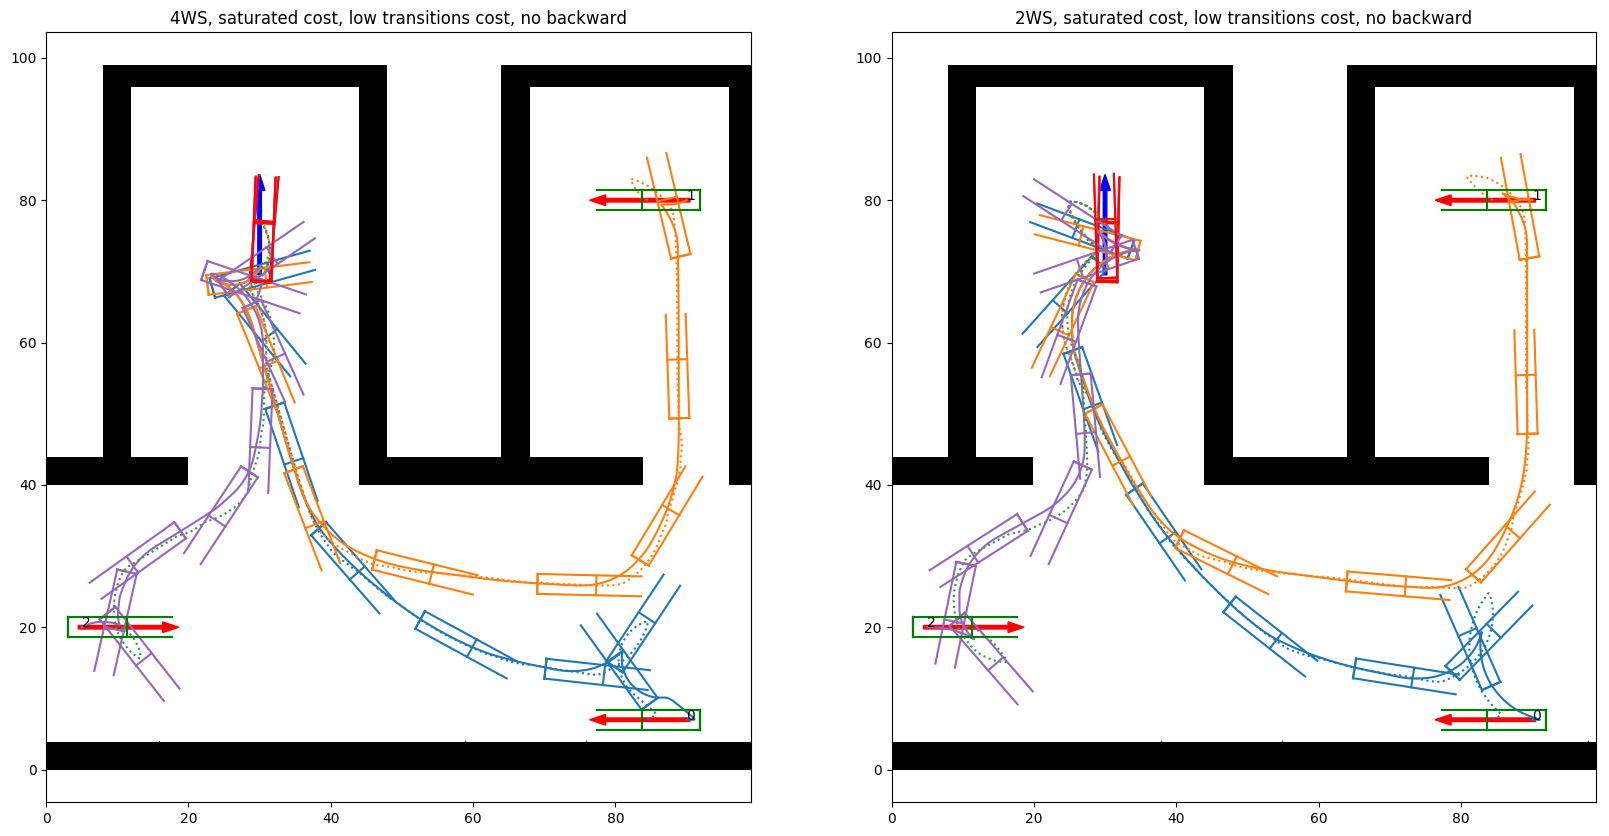

In [35]:
k1 = 1
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, low transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.0), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, low transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.0), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

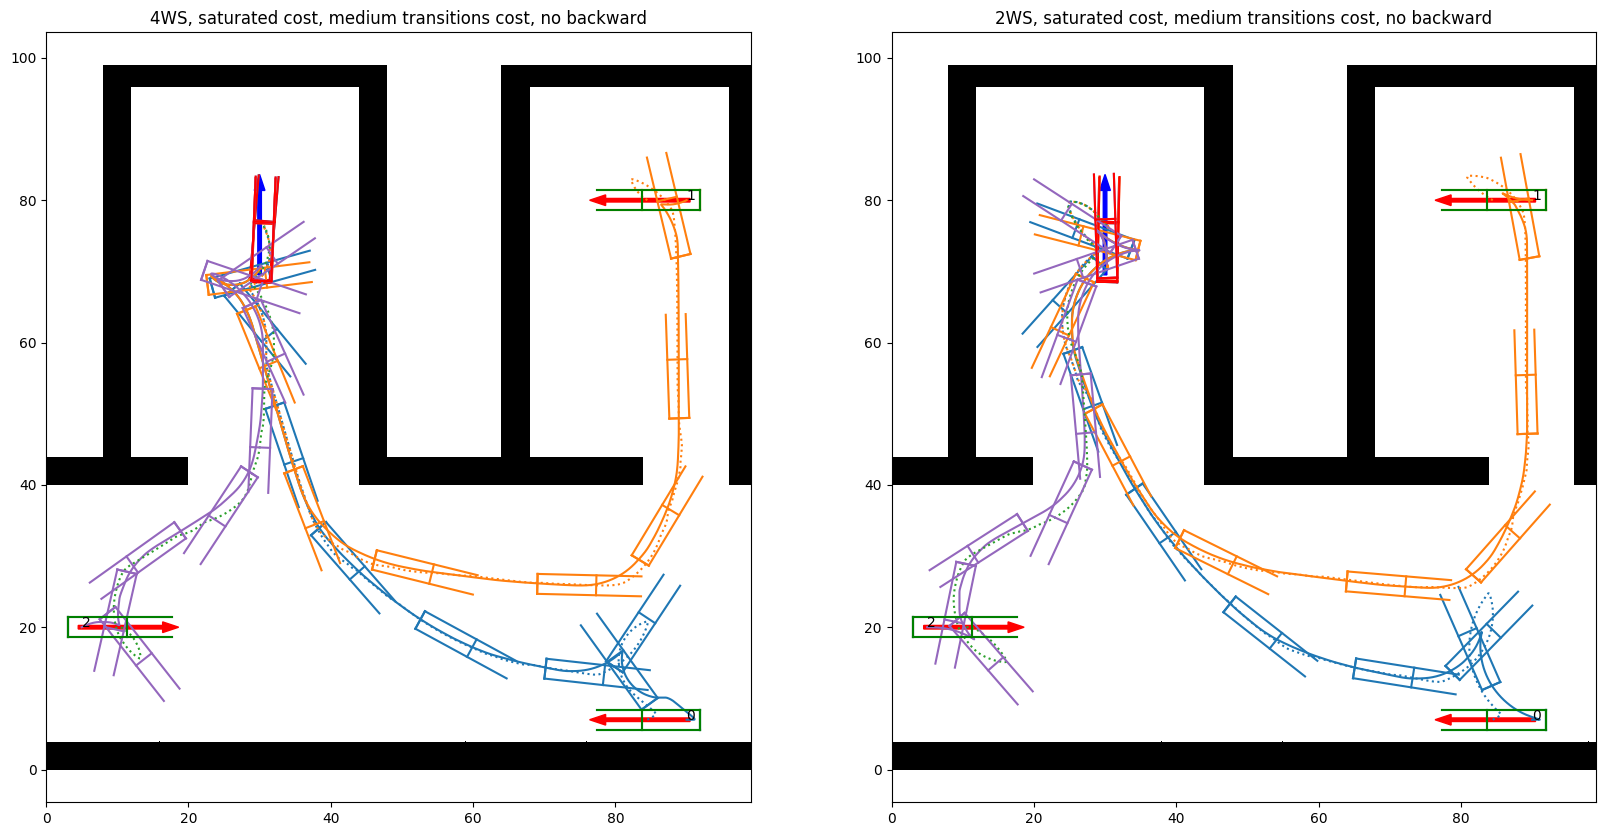

In [36]:
k1 = 1
k2 = 50*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, medium transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, medium transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=1,
                            verbosity=0,
                            transition_cost=transition_cost)

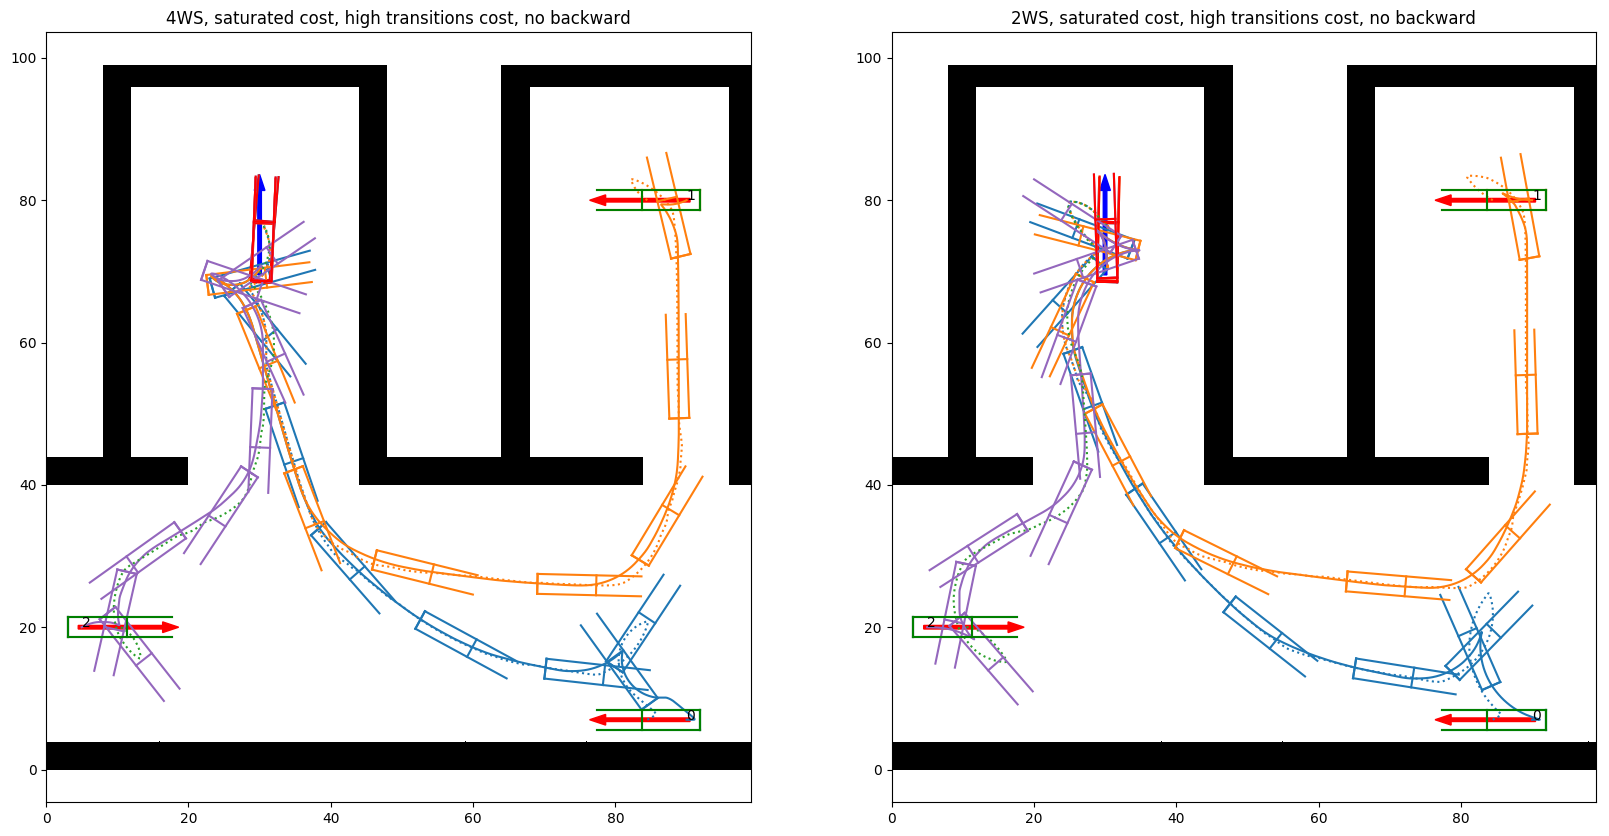

In [37]:
k1 = 200
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, saturated cost, high transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=1.,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, saturated cost, high transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=1.,
                            verbosity=0,
                            transition_cost=transition_cost)

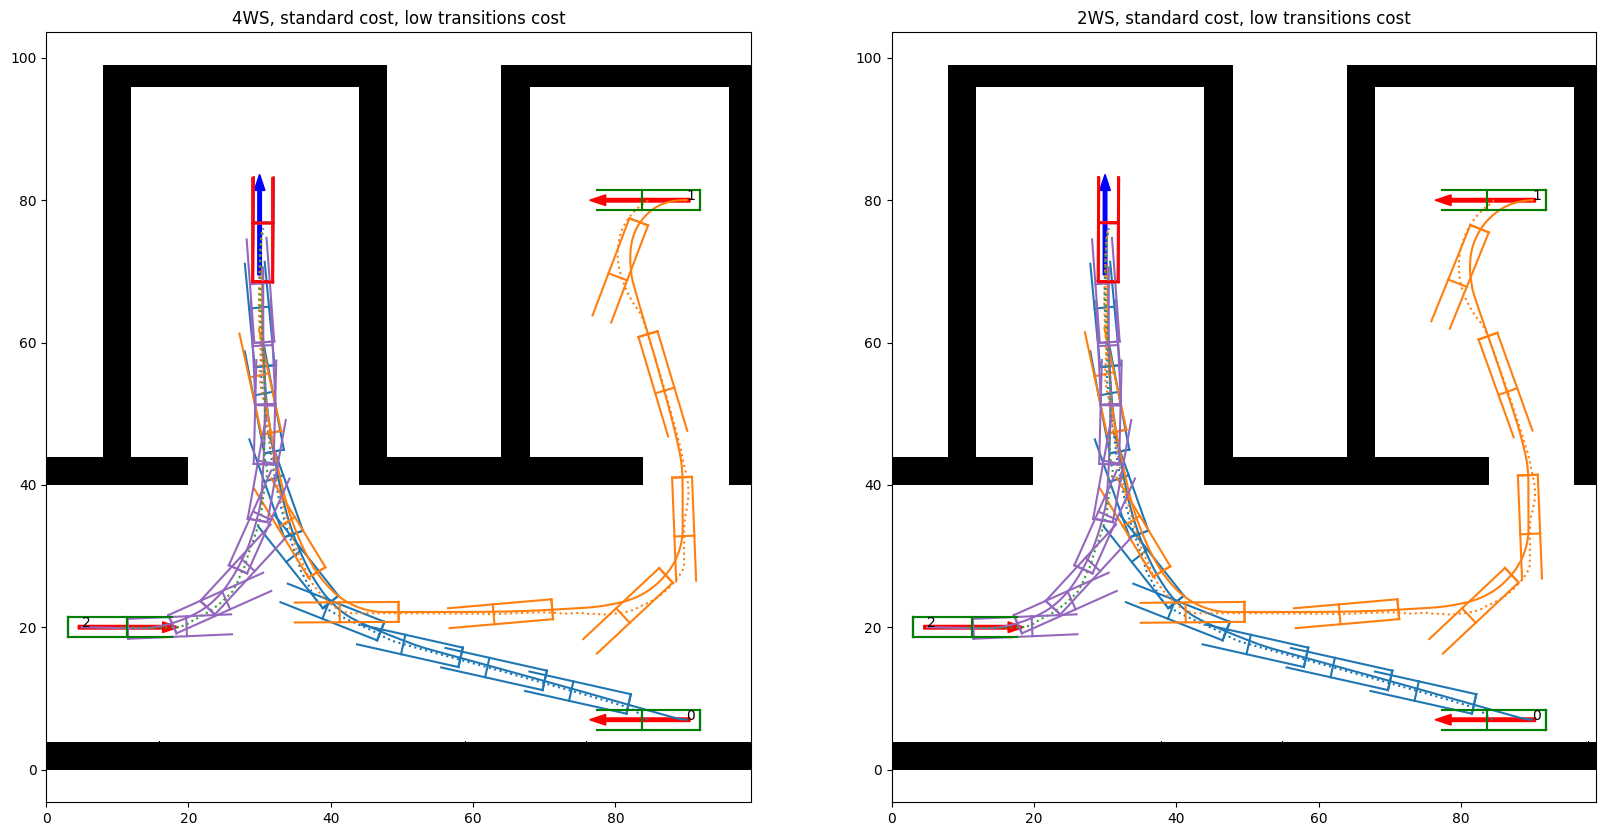

In [38]:
k1 = 1
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, low transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

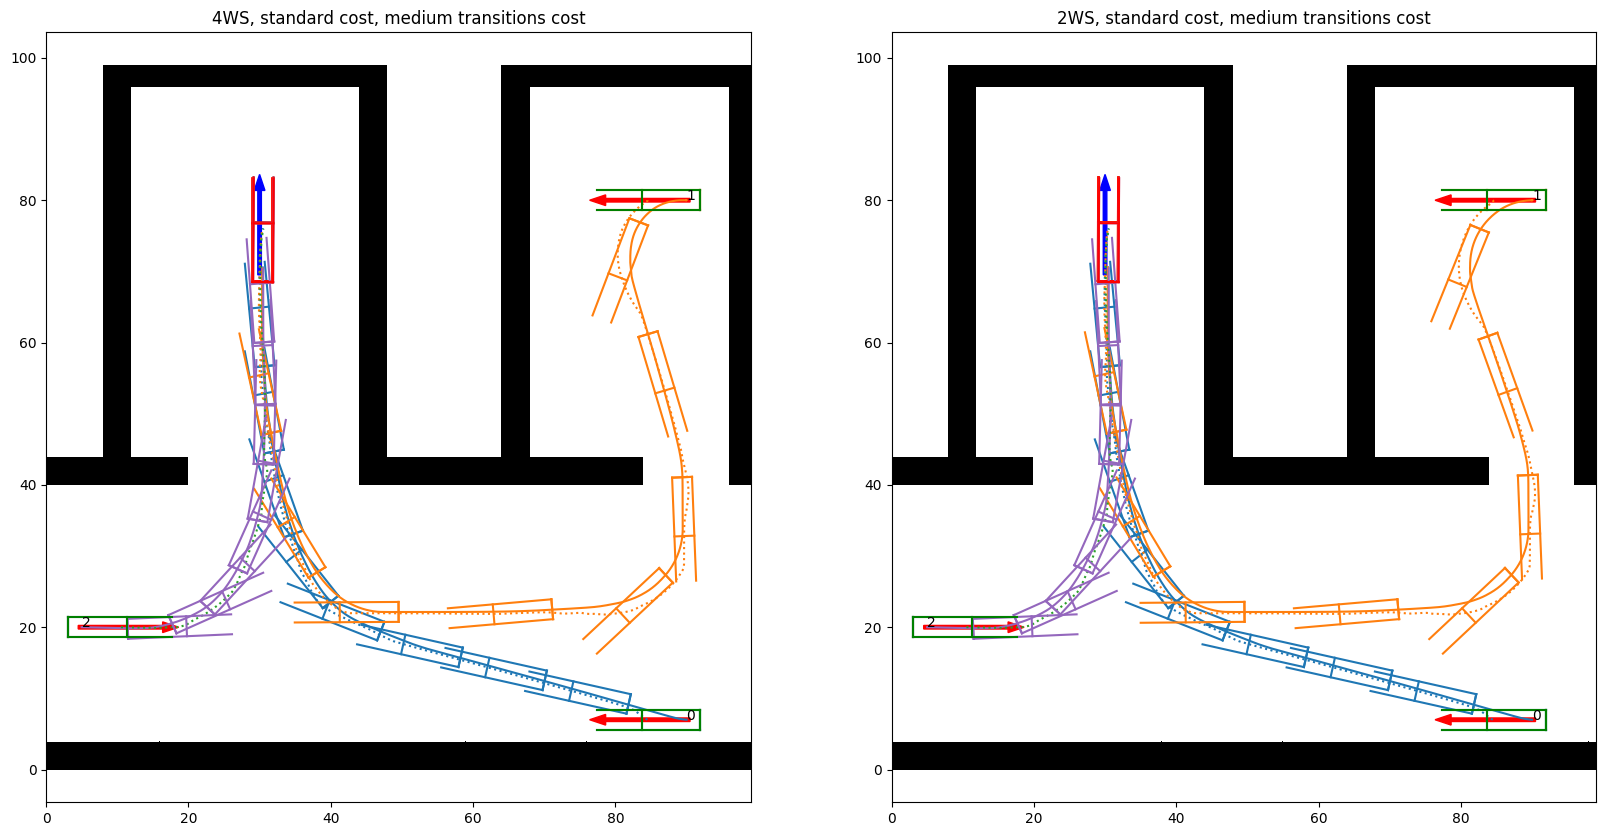

In [39]:
k1 = 1
k2 = 50*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, medium transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, medium transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

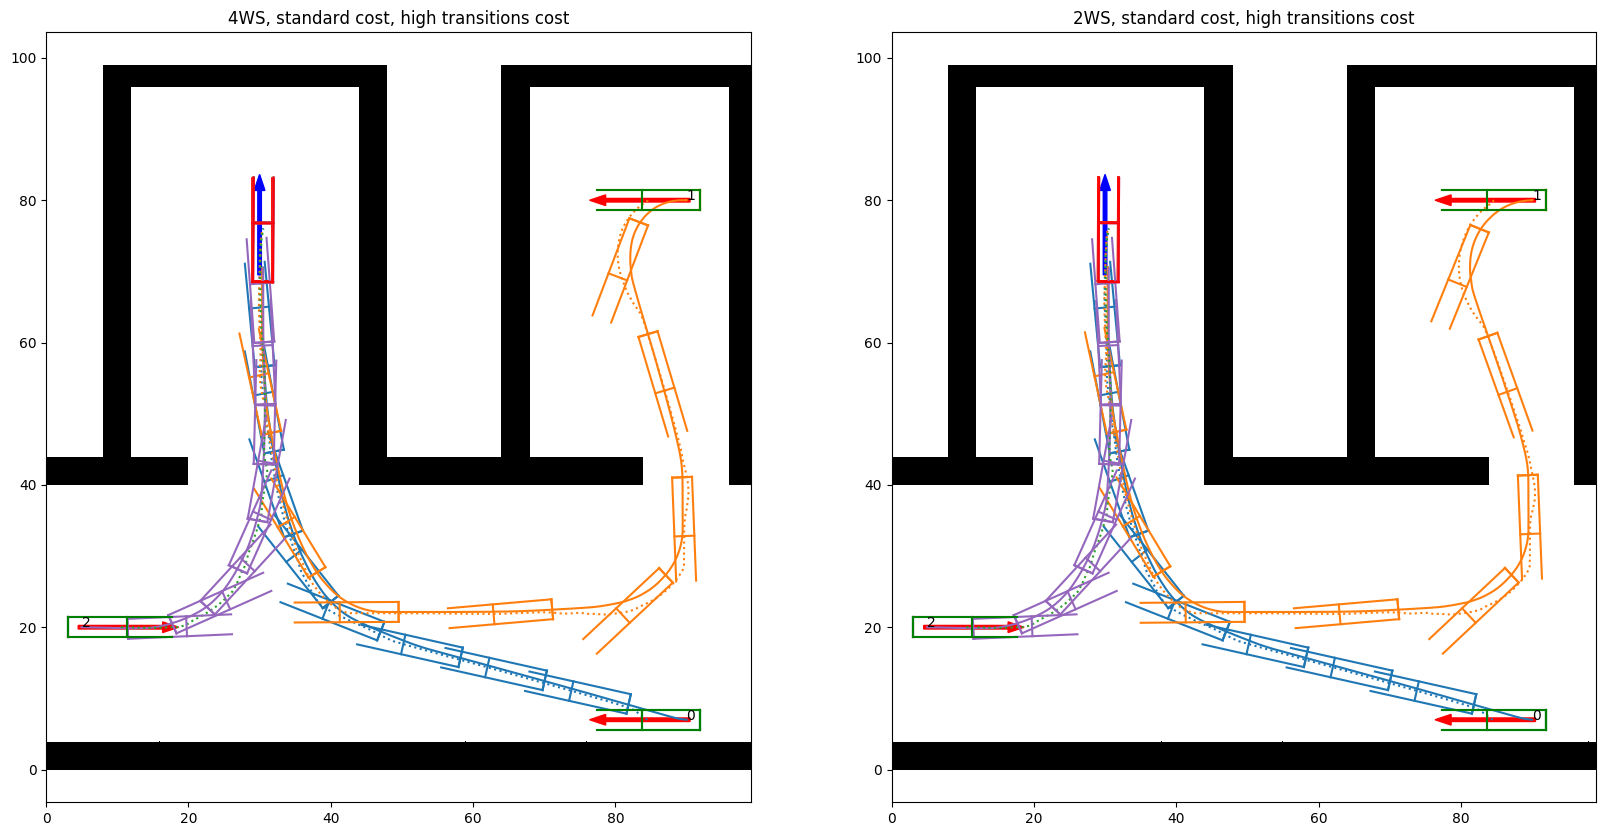

In [40]:
k1 = 200
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, high transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, high transitions cost")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom),
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

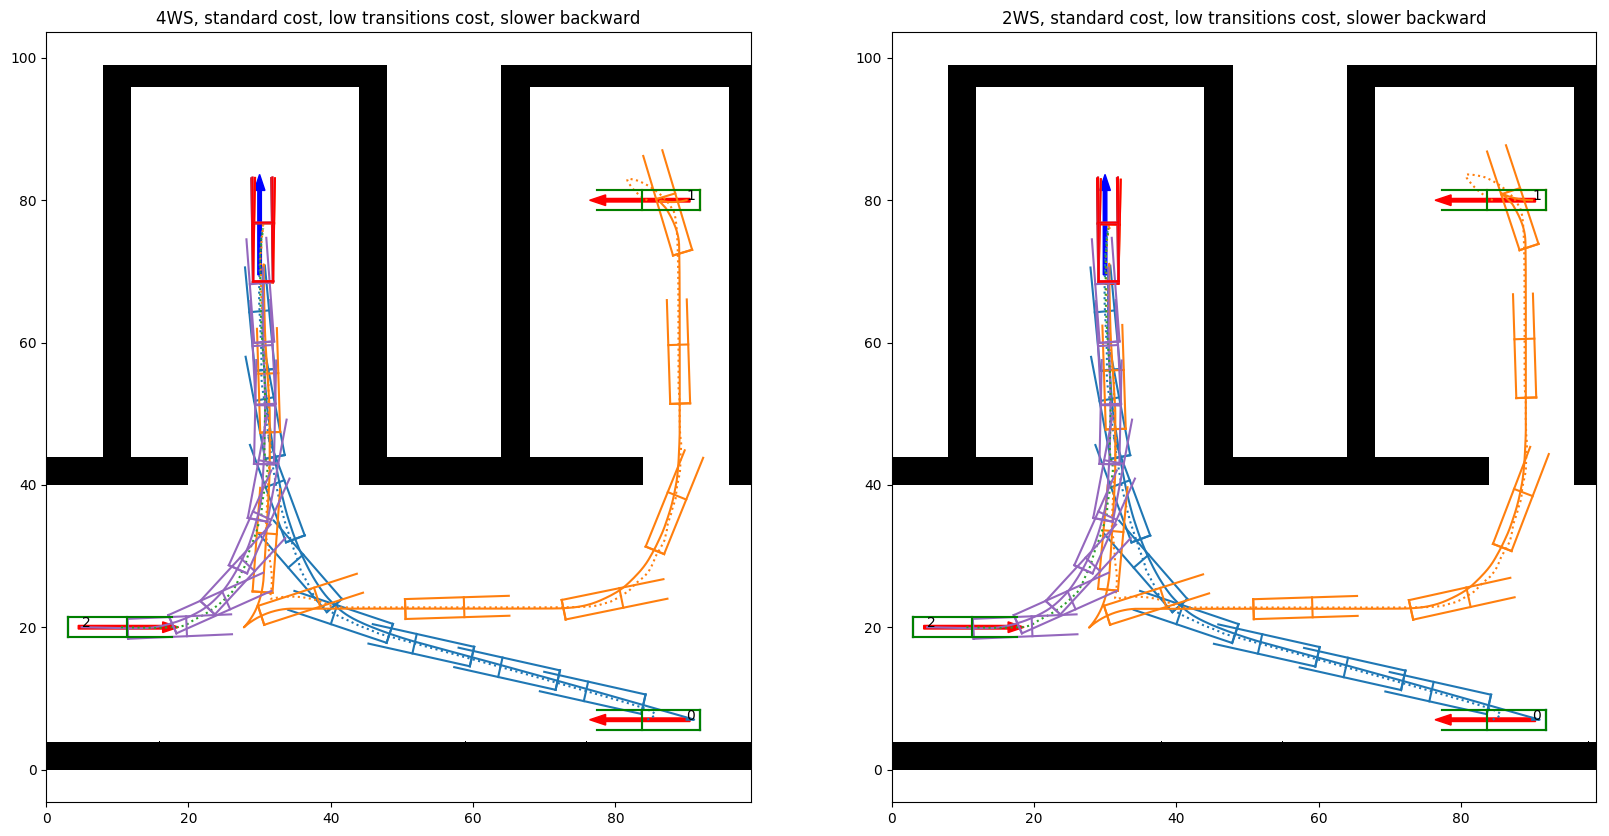

In [41]:
k1 = 1
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, low transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, low transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

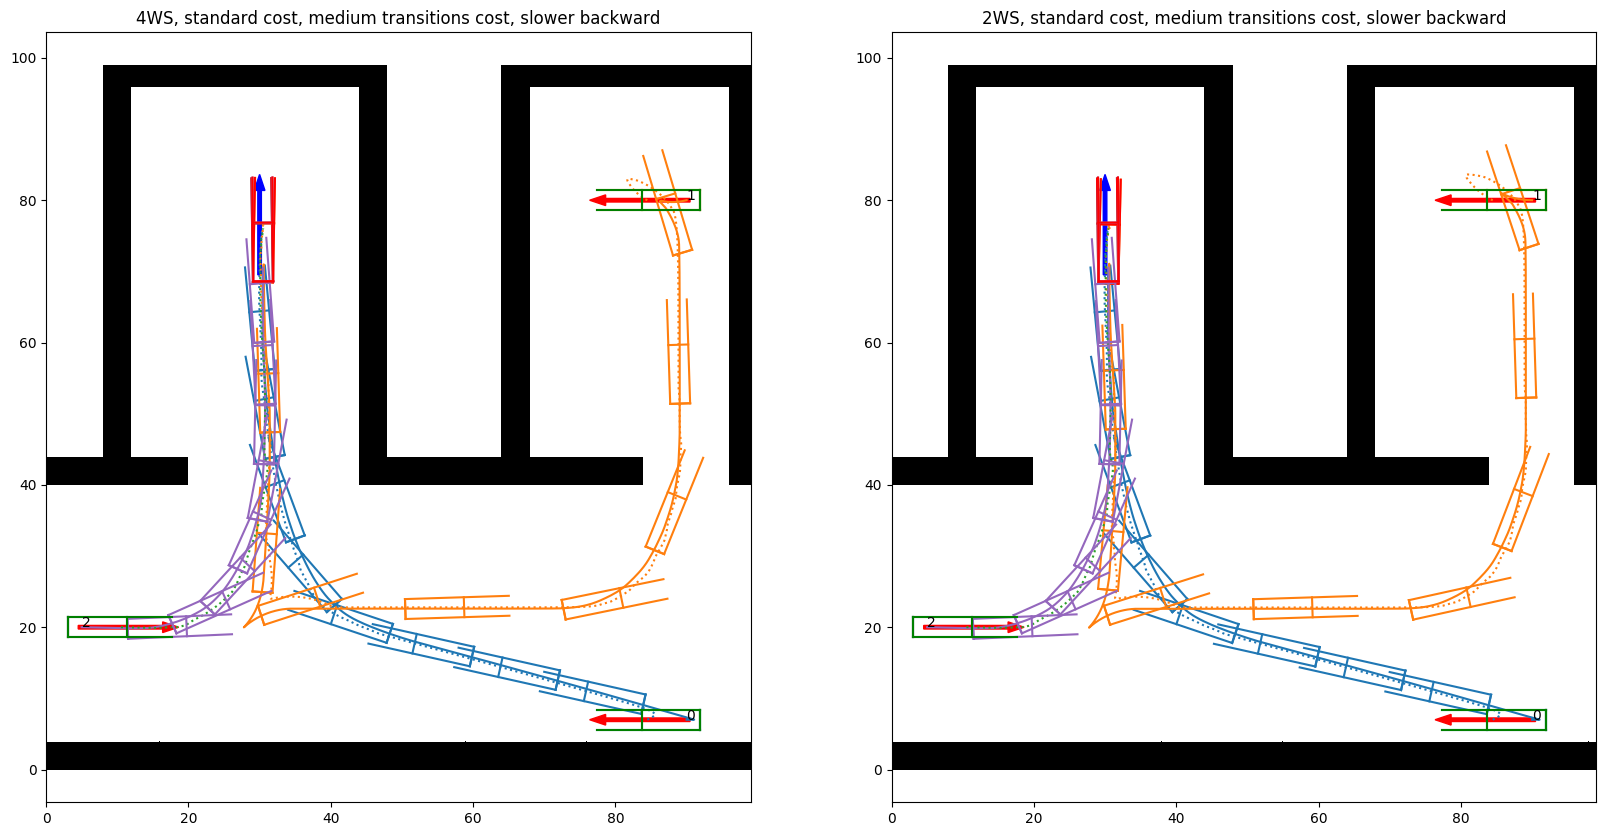

In [42]:
k1 = 1
k2 = 50*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, medium transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, medium transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

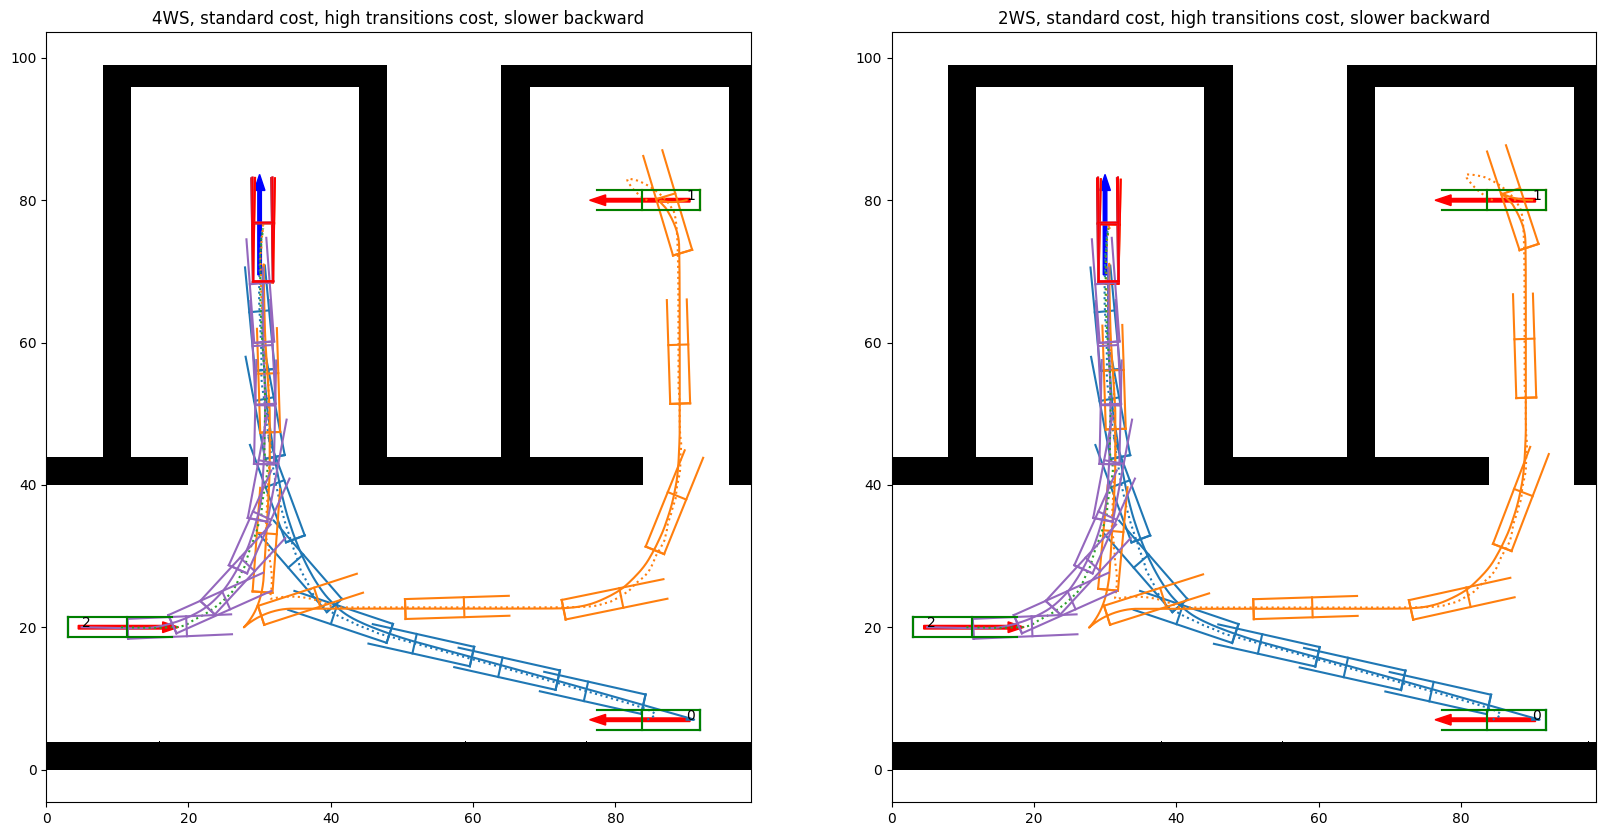

In [43]:
k1 = 200
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, high transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, high transitions cost, slower backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.5), #slower backward motion
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

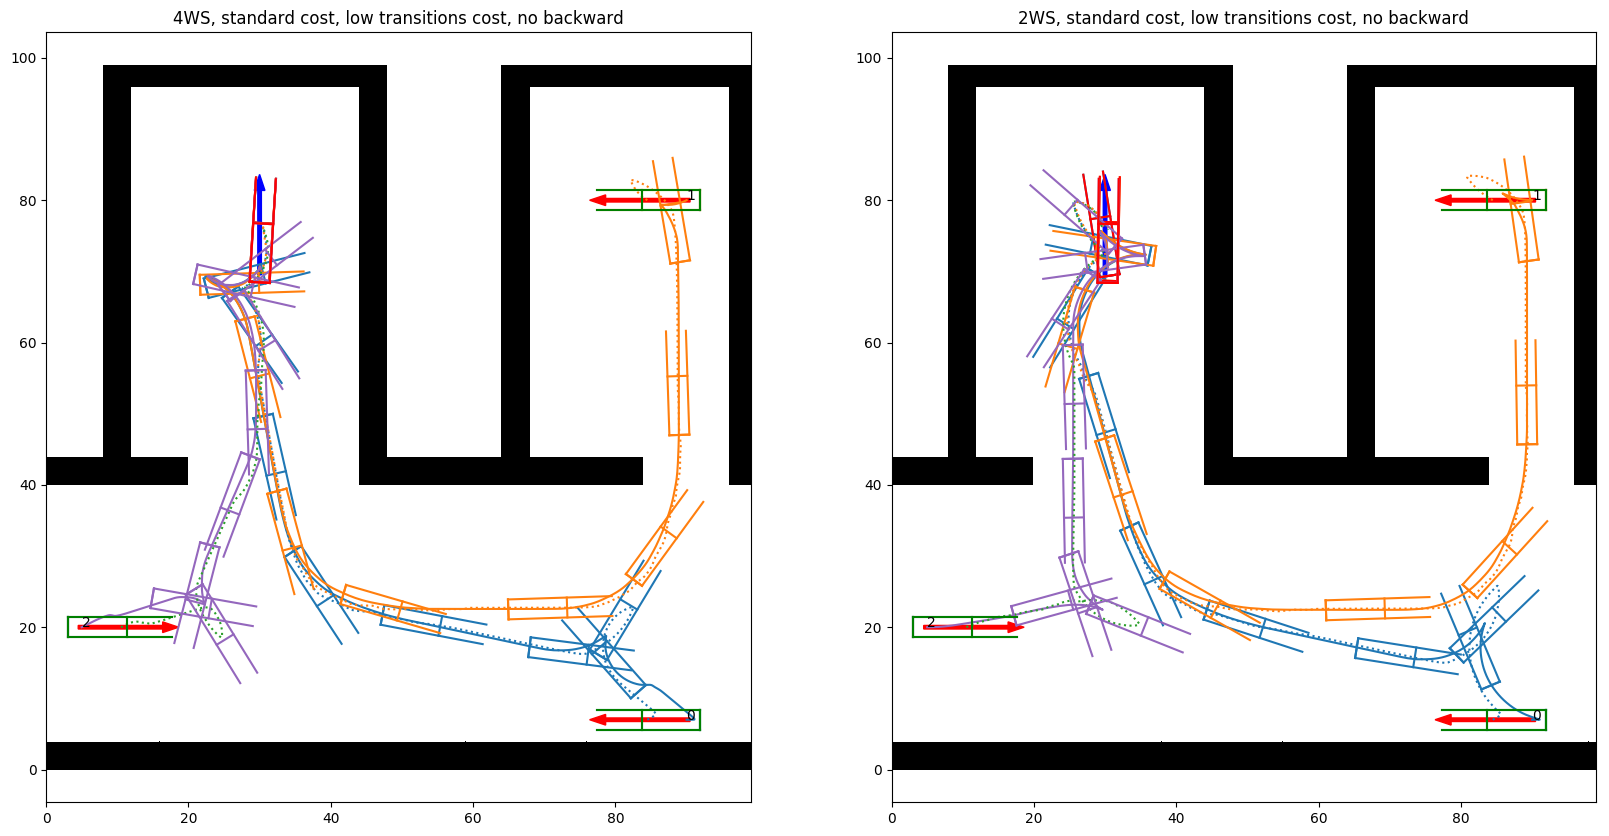

In [44]:
k1 = 1
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, low transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.0), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, low transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.0), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

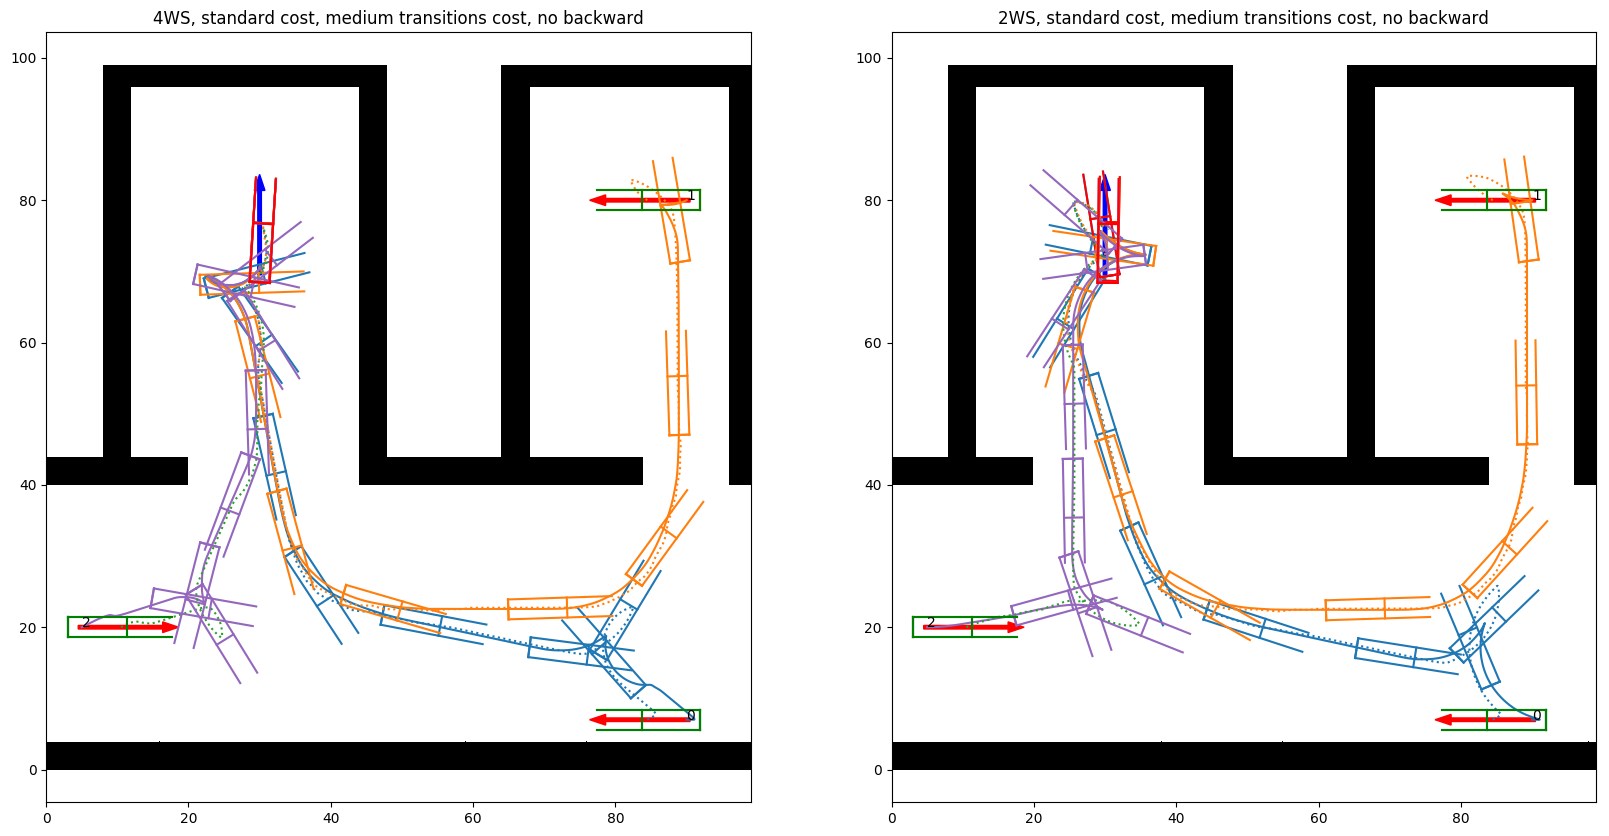

In [45]:
k1 = 1
k2 = 50*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, medium transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, medium transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=0,
                            verbosity=0,
                            transition_cost=transition_cost)

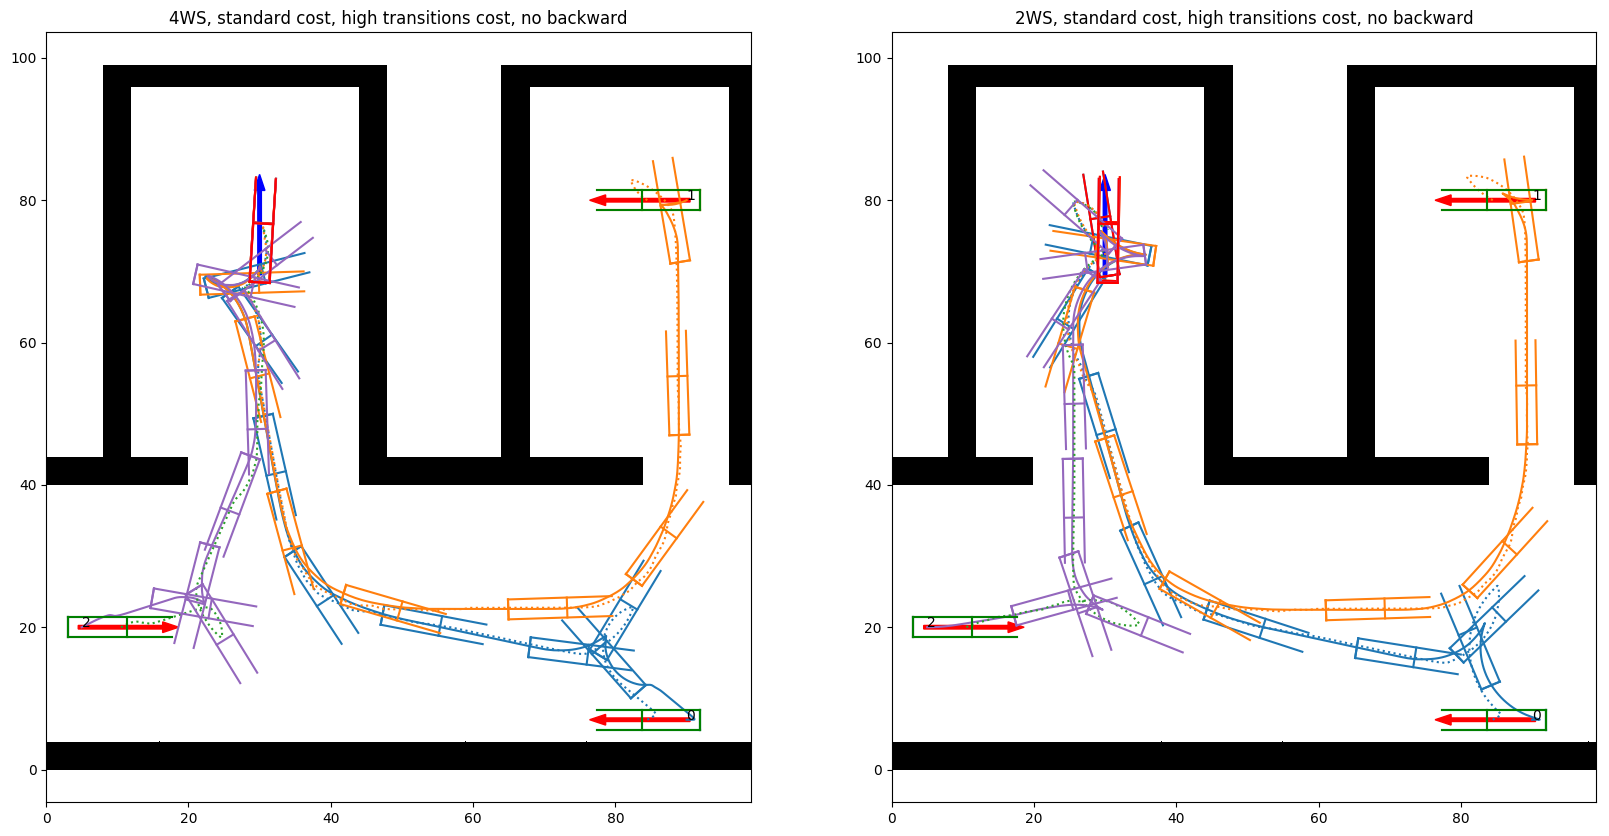

In [46]:
k1 = 200
k2 = 1*k1
# Create state transition cost matrix
# States: [Forward Nav, Forward Maneuver, Backward Maneuver, Backward Nav]
transition_cost = np.array([
    [0,   k2,  k2,  k1],  # From Forward Navigation
    [k2,  0,   1,   k2],  # From Forward Maneuver
    [k2,  1,   0,   k2],  # From Backward Maneuver
    [k1,  k2,  k2,  0]    # From Backward Navigation
])

# Compare 4WS and 2WS systems
plt.figure(figsize=(20,10)) 


plt.subplot(1,2,1)
plt.title("4WS, standard cost, high transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Four_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=0.,
                            verbosity=0,
                            transition_cost=transition_cost)


plt.subplot(1,2,2)
plt.title("2WS, standard cost, high transitions cost, no backward")
hfmIn, hfmOut = run_controls(hfmIn0.copy(),
                            Two_WS_complex_state(Θ,wheelbase_zoom,rev_ratio=0.), #no backward motion, can only use the maneuvre state to go backward
                            fm2=1,
                            saturation=0.,
                            verbosity=0,
                            transition_cost=transition_cost)